# Classificação de Resenhas de Filmes: Aprendizado Automático para Textos

A *Film Junky Union*, uma nova comunidade para entusiastas de filmes clássicos, deseja automatizar a filtragem e categorização de resenhas de filmes. O objetivo é treinar um modelo capaz de classificar automaticamente resenhas como positivas ou negativas.

Para isso, utilizaremos um conjunto de dados do IMDb contendo resenhas rotuladas por polaridade. Nosso objetivo é desenvolver e avaliar diferentes abordagens de processamento de texto e aprendizado de máquina para alcançar um **F1-score de pelo menos 0.85**.

Este projeto demonstrará habilidades fundamentais de NLP (*Natural Language Processing*), incluindo **pré-processamento de texto, vetorização, aprendizado de máquina e avaliação de modelos**.

## Descrição dos Dados

Os dados são armazenados no arquivo `imdb_reviews.tsv`.

Os dados foram fornecidos por **Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng e Christopher Potts** (2011) no trabalho *Vetores de aprendizado de palavras para análise de sentimentos*, apresentado na 49ª Reunião Anual da *Association for Computational Linguistics* (ACL 2011).

### Campos selecionados:

- **review**: o texto da resenha.
- **pos**: a polaridade da resenha, onde `'0'` indica negativo e `'1'` indica positivo.
- **ds_part**: indica a parte do conjunto de dados, sendo `'train'` para treinamento e `'test'` para teste.

Há outros campos no conjunto de dados. Sinta-se à vontade para explorá-los se desejar.

## Inicialização

In [1]:
# Importações essenciais

# Manipulação de dados
import os
import numpy as np
import pandas as pd

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bar
from tqdm.auto import tqdm

# Processamento de Linguagem Natural (NLP)
import re
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import spacy

# Garantir que os recursos necessários do NLTK estão disponíveis
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Machine Learning
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

# Modelos Avançados
import torch
import transformers
from lightgbm import LGBMClassifier

print("Bibliotecas carregadas com sucesso.")


[nltk_data] Downloading package punkt to C:\Users\bruno/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bruno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\bruno/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\bruno/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Bibliotecas carregadas com sucesso.


In [2]:
# Configurações gerais
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Melhor qualidade para telas HiDPI
plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
# Habilitando barra de progresso no Pandas
tqdm.pandas()

## Carregar Dados

In [4]:
df_reviews = pd.read_csv('datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
# Exibir as primeiras linhas para inspeção com separador
print(df_reviews.head(), end="\n\n" + "-" * 100 + "\n")

# Exibir informações gerais sobre o dataset
print(df_reviews.info(), end="\n\n" + "-" * 100 + "\n")

# Resumo estatístico das colunas numéricas
print(df_reviews.describe(include='all'), end="\n\n" + "-" * 100 + "\n")

      tconst title_type primary_title original_title  start_year end_year  \
0  tt0068152      movie             $              $        1971       \N   
1  tt0068152      movie             $              $        1971       \N   
2  tt0313150      short          '15'           '15'        2002       \N   
3  tt0313150      short          '15'           '15'        2002       \N   
4  tt0313150      short          '15'           '15'        2002       \N   

  runtime_minutes  is_adult              genres  average_rating  votes  \
0             121         0  Comedy,Crime,Drama             6.3   2218   
1             121         0  Comedy,Crime,Drama             6.3   2218   
2              25         0  Comedy,Drama,Short             6.3    184   
3              25         0  Comedy,Drama,Short             6.3    184   
4              25         0  Comedy,Drama,Short             6.3    184   

                                              review  rating   sp  pos  \
0  The pakage impl

## Análise Inicial dos Dados

### Observações Gerais
O dataset contém **47.331 resenhas** de filmes, com informações sobre título, ano de lançamento, tempo de duração, gêneros e avaliações. Além disso, as resenhas são rotuladas como **positivas (1) ou negativas (0)** para fins de aprendizado de máquina.

### Estrutura do Dataset
- O conjunto de dados possui **17 colunas**, sendo:
  - **Campos de identificação:** `tconst` (ID do IMDb)
  - **Metadados do filme:** `title_type`, `primary_title`, `original_title`, `start_year`, `end_year`, `runtime_minutes`, `genres`
  - **Características numéricas:** `average_rating`, `votes`
  - **Texto da resenha:** `review`
  - **Rotulação:** `rating`, `pos`
  - **Divisão do dataset:** `ds_part` (`train` ou `test`)

### Possíveis Problemas Identificados
1. **Valores ausentes e inconsistências:**
   - **`end_year`** contém valores `\N`, indicando possíveis ausências.
   - **`runtime_minutes`** está como `object` em vez de numérico.
   - **`average_rating` e `votes`** possuem **dois valores ausentes**.

2. **Distribuição das classes (`pos`):**
   - A classificação está **equilibrada** (~50% positivo e ~50% negativo), o que favorece modelos de aprendizado de máquina.

3. **Características do texto das resenhas:**
   - A coluna `review` contém **47.240 textos únicos**, indicando uma pequena quantidade de duplicações.

### Impacto nas Próximas Etapas
- **Pré-processamento de texto:** Será necessário remover duplicatas e tratar valores ausentes antes da modelagem.
- **Conversão de tipos:** `runtime_minutes` e `end_year` precisam ser transformados para análise quantitativa.
- **Possível engenharia de features:** `genres`, `title_type` e `average_rating` podem ser explorados para melhorar as previsões.


In [6]:
# Identificar possíveis duplicatas considerando título, ano e resenha
duplicatas = df_reviews.duplicated(subset=['primary_title', 'start_year', 'review'], keep=False)
print(f"Registros potencialmente duplicados: {duplicatas.sum()}")

# Remover apenas duplicatas exatas (caso existam)
df_reviews = df_reviews.drop_duplicates(subset=['primary_title', 'start_year', 'review'])
print(f"Total de registros após remoção de duplicatas: {df_reviews.shape[0]}")

Registros potencialmente duplicados: 169
Total de registros após remoção de duplicatas: 47242


In [7]:
# Substituir '\N' por NaN para facilitar tratamento
df_reviews.replace('\\N', np.nan, inplace=True)

# Converter runtime_minutes e end_year para valores numéricos
df_reviews['runtime_minutes'] = pd.to_numeric(df_reviews['runtime_minutes'], errors='coerce')
df_reviews['end_year'] = pd.to_numeric(df_reviews['end_year'], errors='coerce')

# Verificar valores ausentes após conversão
print(df_reviews[['runtime_minutes', 'end_year']].isna().sum())

runtime_minutes      488
end_year           44969
dtype: int64


## AED

### Distribuição Temporal e de Resenhas
Analisaremos a distribuição temporal dos filmes e resenhas para compreender:
1. Evolução do volume de filmes ao longo do tempo
2. Distribuição de resenhas positivas e negativas
3. Média de resenhas por filme em diferentes períodos

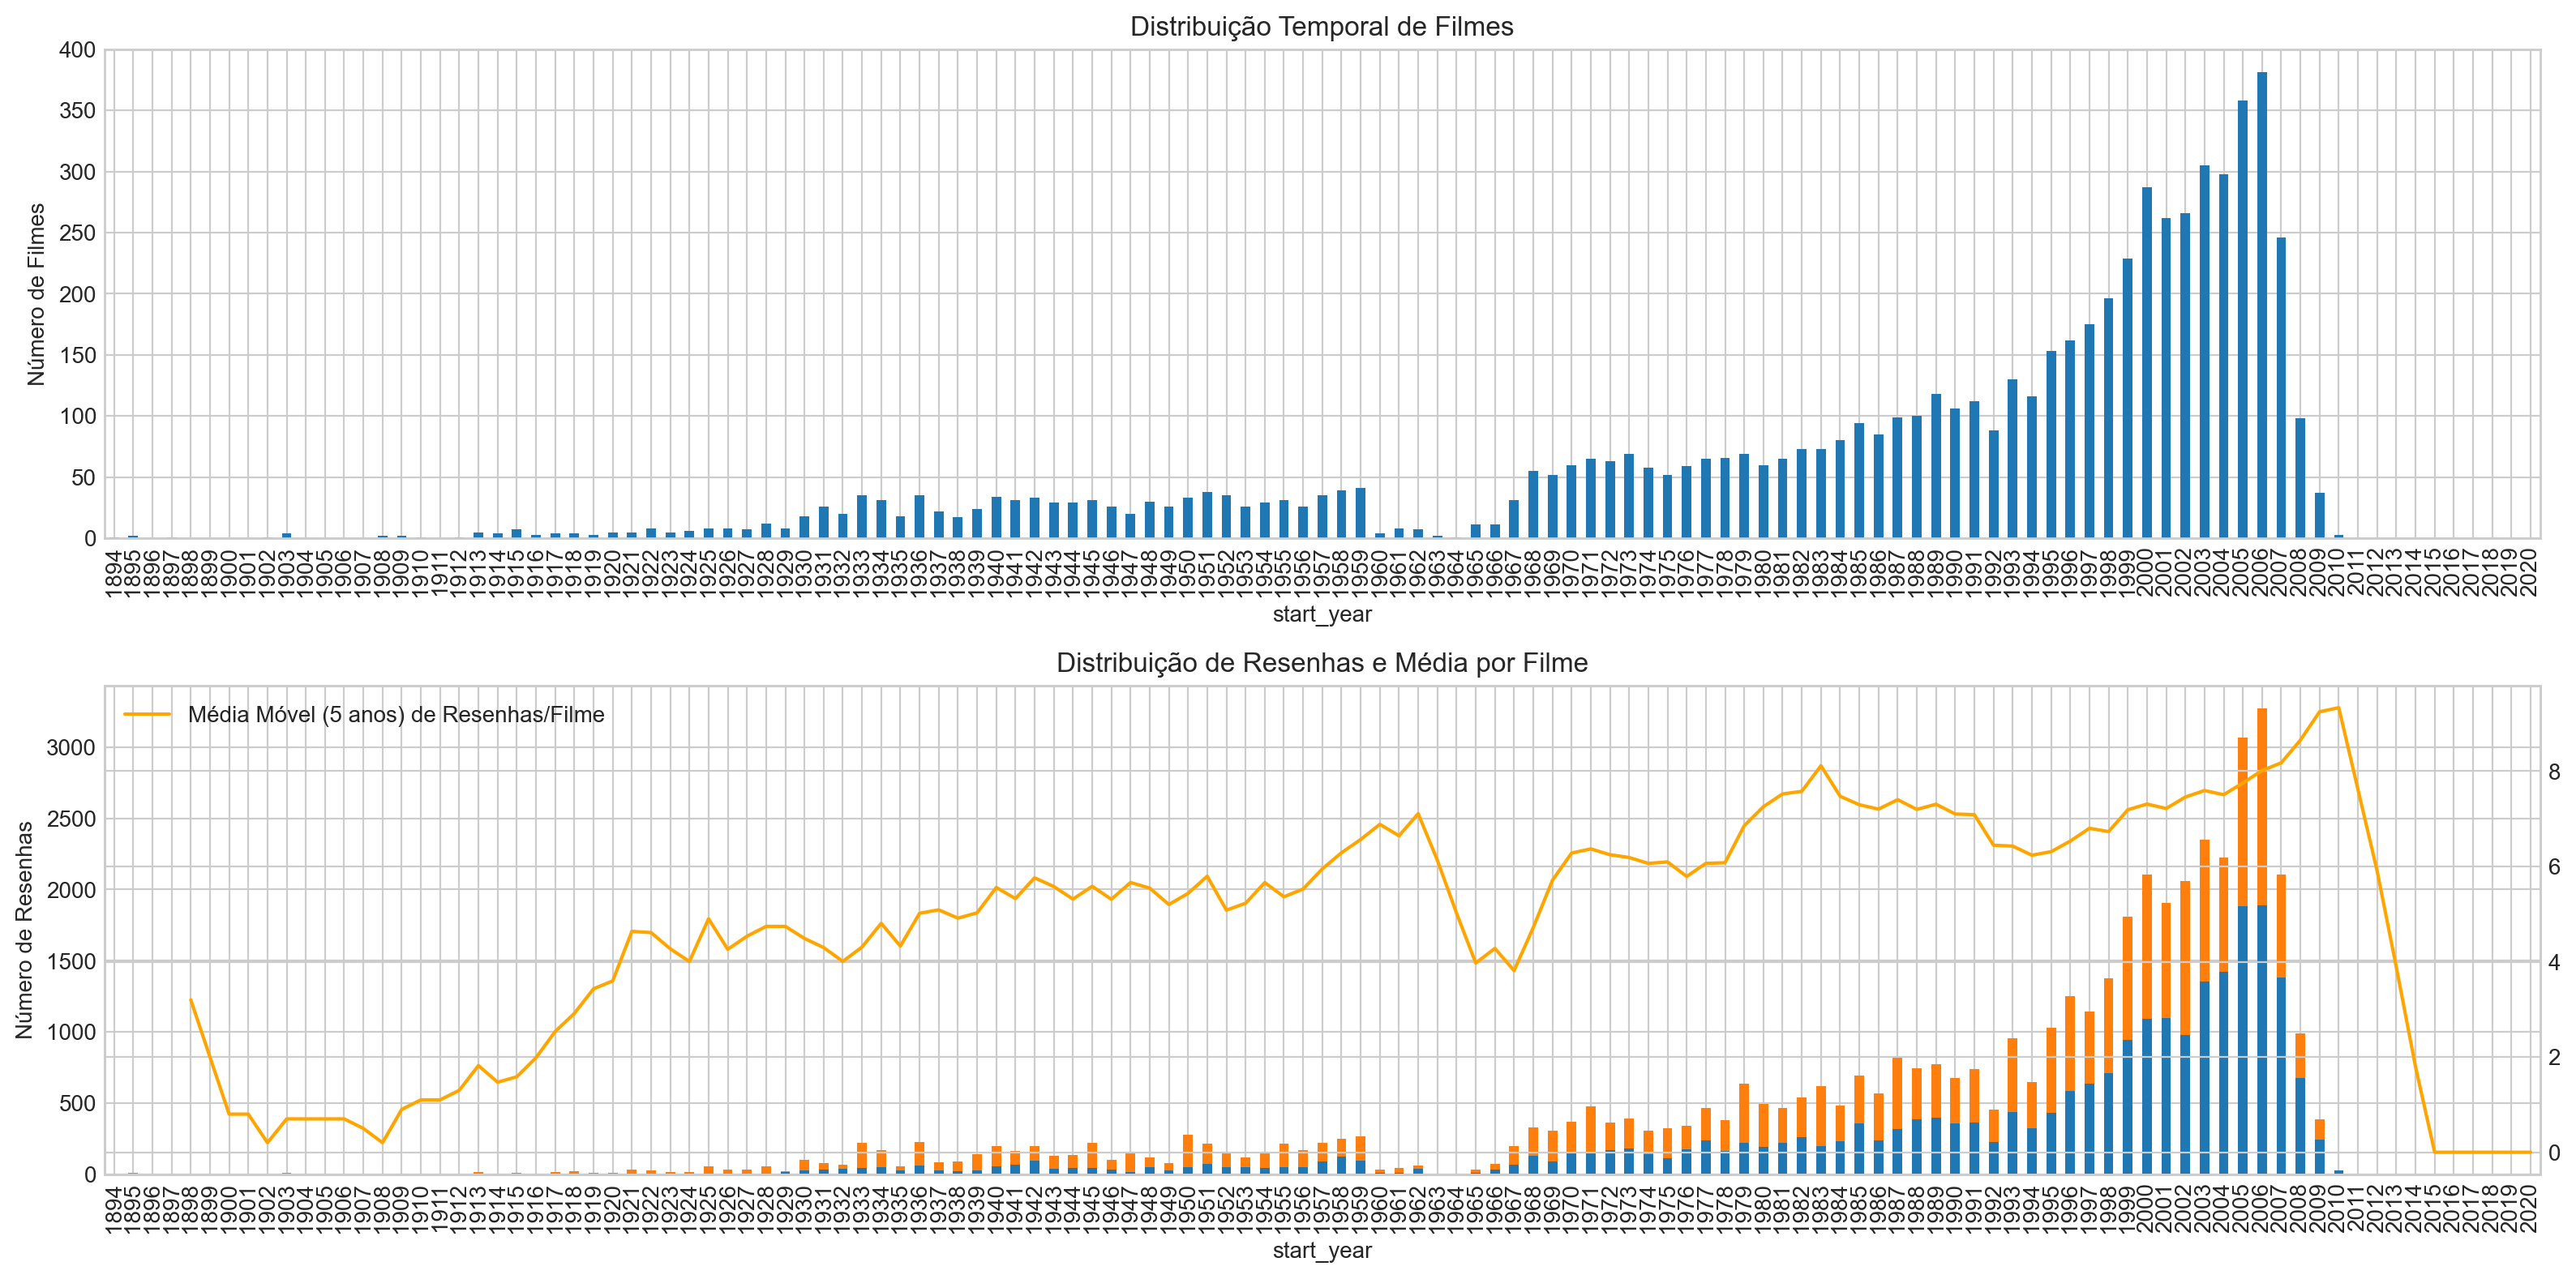

In [8]:
# Configuração dos subplots
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# Gráfico superior: Número de filmes por ano
ax = axs[0]
dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Distribuição Temporal de Filmes')
ax.set_ylabel('Número de Filmes')

# Gráfico inferior: Resenhas por ano e polaridade
ax = axs[1]
dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft2.plot(kind='bar', stacked=True, label=['Negativas', 'Positivas'], ax=ax)

# Média móvel de resenhas por filme
dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', 
    label='Média Móvel (5 anos) de Resenhas/Filme', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')
ax.set_title('Distribuição de Resenhas e Média por Filme')
ax.set_ylabel('Número de Resenhas')

plt.tight_layout()

### Observações da Análise Temporal:

1. **Produção Cinematográfica**:
  - Crescimento consistente ao longo das décadas, com aumento acentuado entre 1980-2000
  - Pico de produção em 2008 
  - Declínio gradual após 2008, refletindo possíveis mudanças na indústria ou metodologia de coleta

2. **Volume de Resenhas**:
  - Acompanha diretamente o padrão de produção de filmes
  - Maior concentração de resenhas entre 1990-2008
  - Proporção equilibrada entre resenhas positivas e negativas
  - Picos de engajamento coincidentes com períodos de maior produção

3. **Média de Resenhas por Filme**:
  - Representada pela linha laranja, mostra flutuações ao longo dos anos
  - Mantém tendência geral de crescimento apesar das oscilações
  - Indica evolução no engajamento do público, mesmo com menos filmes
  - Sugere maior participação dos usuários em avaliações por filme

Estas tendências demonstram uma clara evolução tanto no volume de produção cinematográfica quanto no interesse público em avaliar filmes, especialmente entre as décadas de 1980 e 2000. A queda após 2008 pode refletir mudanças estruturais na indústria ou alterações na metodologia de coleta de dados.

---

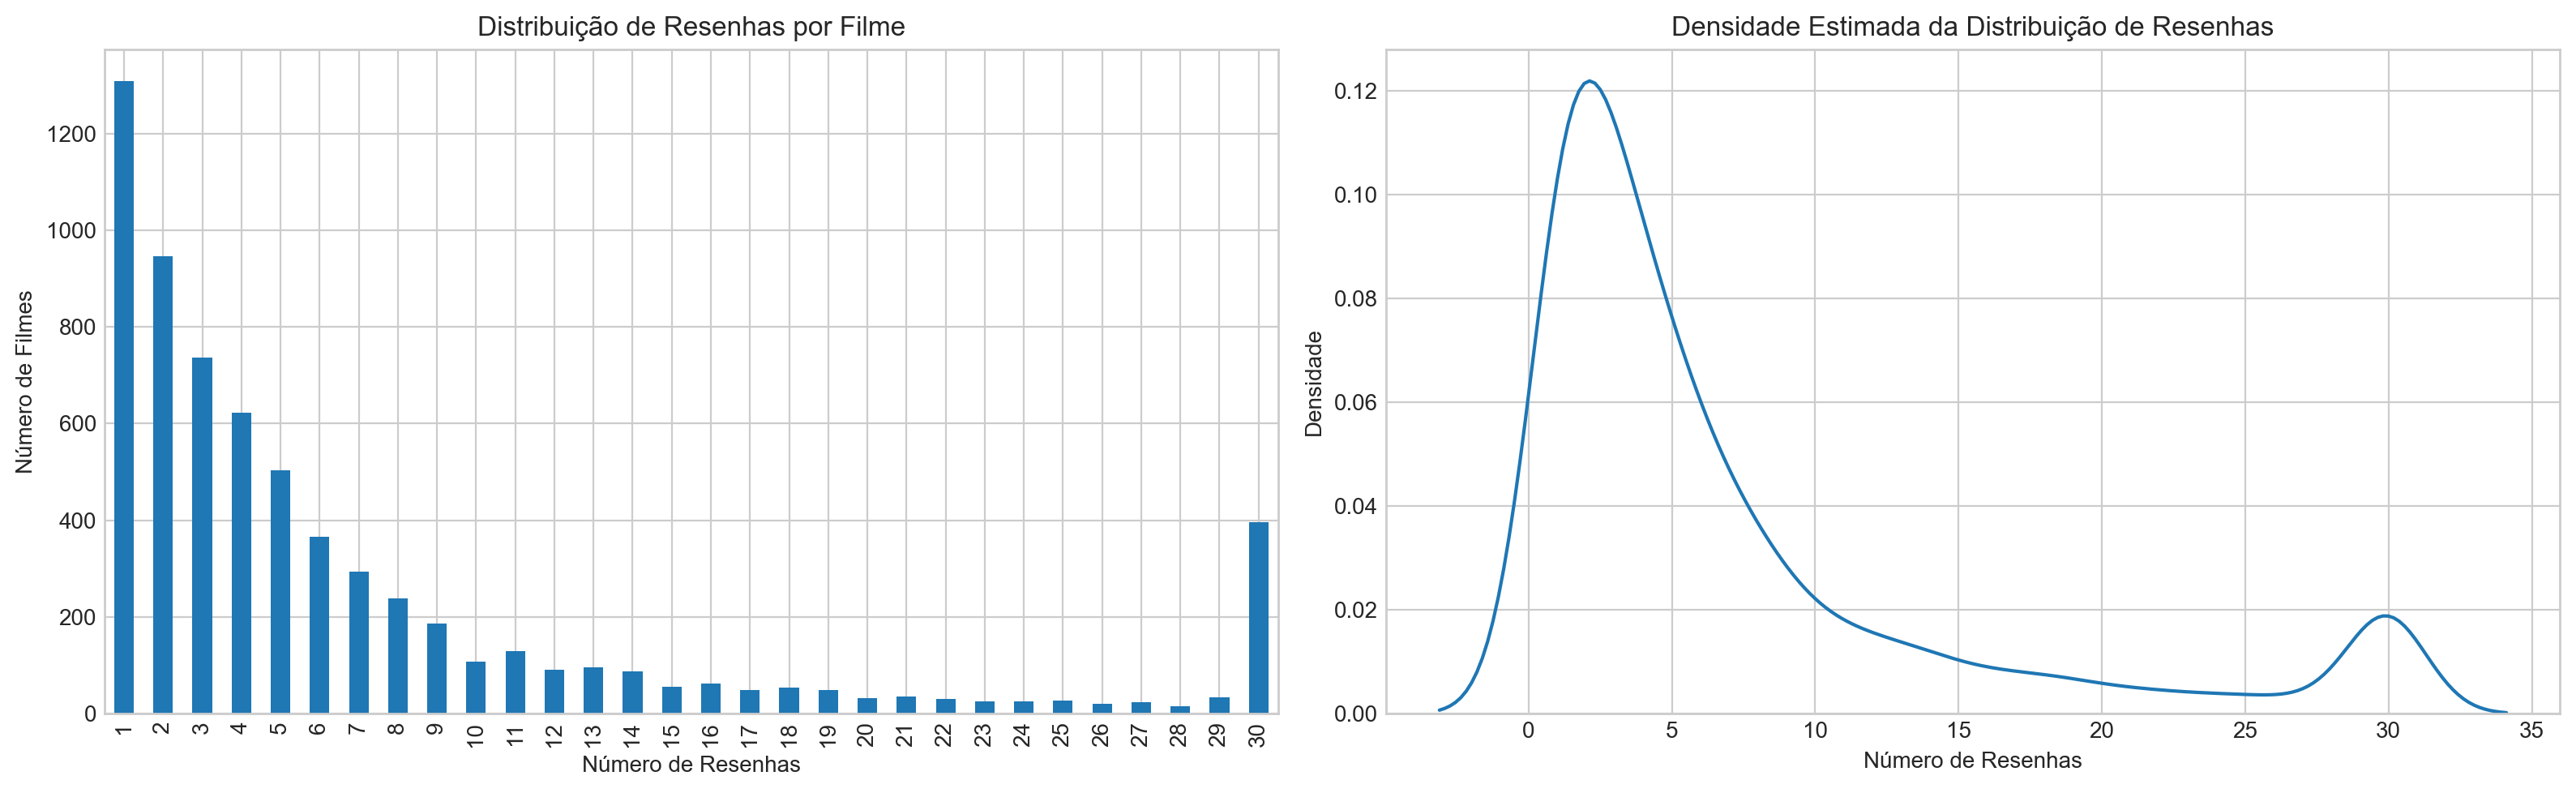

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Gráfico de Barras: Contagem de Resenhas
ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Distribuição de Resenhas por Filme')
ax.set_xlabel('Número de Resenhas')
ax.set_ylabel('Número de Filmes')

# EDK: Distribuição Suavizada
ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Densidade Estimada da Distribuição de Resenhas')
ax.set_xlabel('Número de Resenhas')
ax.set_ylabel('Densidade')

fig.tight_layout()

### Análise da Distribuição de Resenhas por Filme

Analisaremos a distribuição do número de resenhas por filme usando duas abordagens complementares:

1. **Contagem Exata**: Gráfico de barras mostrando a frequência real de resenhas por filme
2. **Estimativa de Densidade Kernel (EDK)**: Método não-paramétrico que suaviza a distribuição, permitindo visualizar padrões subjacentes que podem não ser evidentes na contagem bruta

A EDK é particularmente útil neste contexto pois:
- Reduz o ruído dos dados discretos
- Facilita a identificação de características da distribuição
- Permite melhor visualização da forma geral da distribuição

### Observações da Distribuição:

1. **Concentração de Resenhas**:
  - Forte assimetria positiva na distribuição
  - Maioria dos filmes recebe poucas resenhas (1-2)
  - Diminuição exponencial na frequência conforme aumenta o número de resenhas

2. **Análise por Visualização**:
  - **Gráfico de Barras**:
    - Demonstra concentração clara em filmes com poucas resenhas
    - Evidencia diminuição gradual na frequência com o aumento do número de resenhas
  - **EDK**:
    - Confirma o padrão de concentração em baixos números de resenhas
    - Revela pequeno pico secundário, sugerindo subgrupo de filmes populares

3. **Implicações para o Modelo**:
  - Dados apresentam viés em relação a filmes menos populares
  - Subconjunto pequeno de filmes atrai volume desproporcionalmente alto de resenhas
  - Necessário considerar este desequilíbrio no desenvolvimento do modelo de classificação

Esta análise dual nos permite compreender melhor a estrutura dos dados e identificar potenciais desafios para o desenvolvimento do modelo de classificação.

---

### Análise da Distribuição de Polaridade

Examinaremos a distribuição das classificações positivas e negativas nos conjuntos de treino e teste para:
1. Verificar o balanço entre classes
2. Avaliar a consistência da distribuição entre os conjuntos
3. Identificar potenciais vieses na divisão dos dados

In [10]:
df_reviews['pos'].value_counts()

pos
0    23680
1    23562
Name: count, dtype: int64

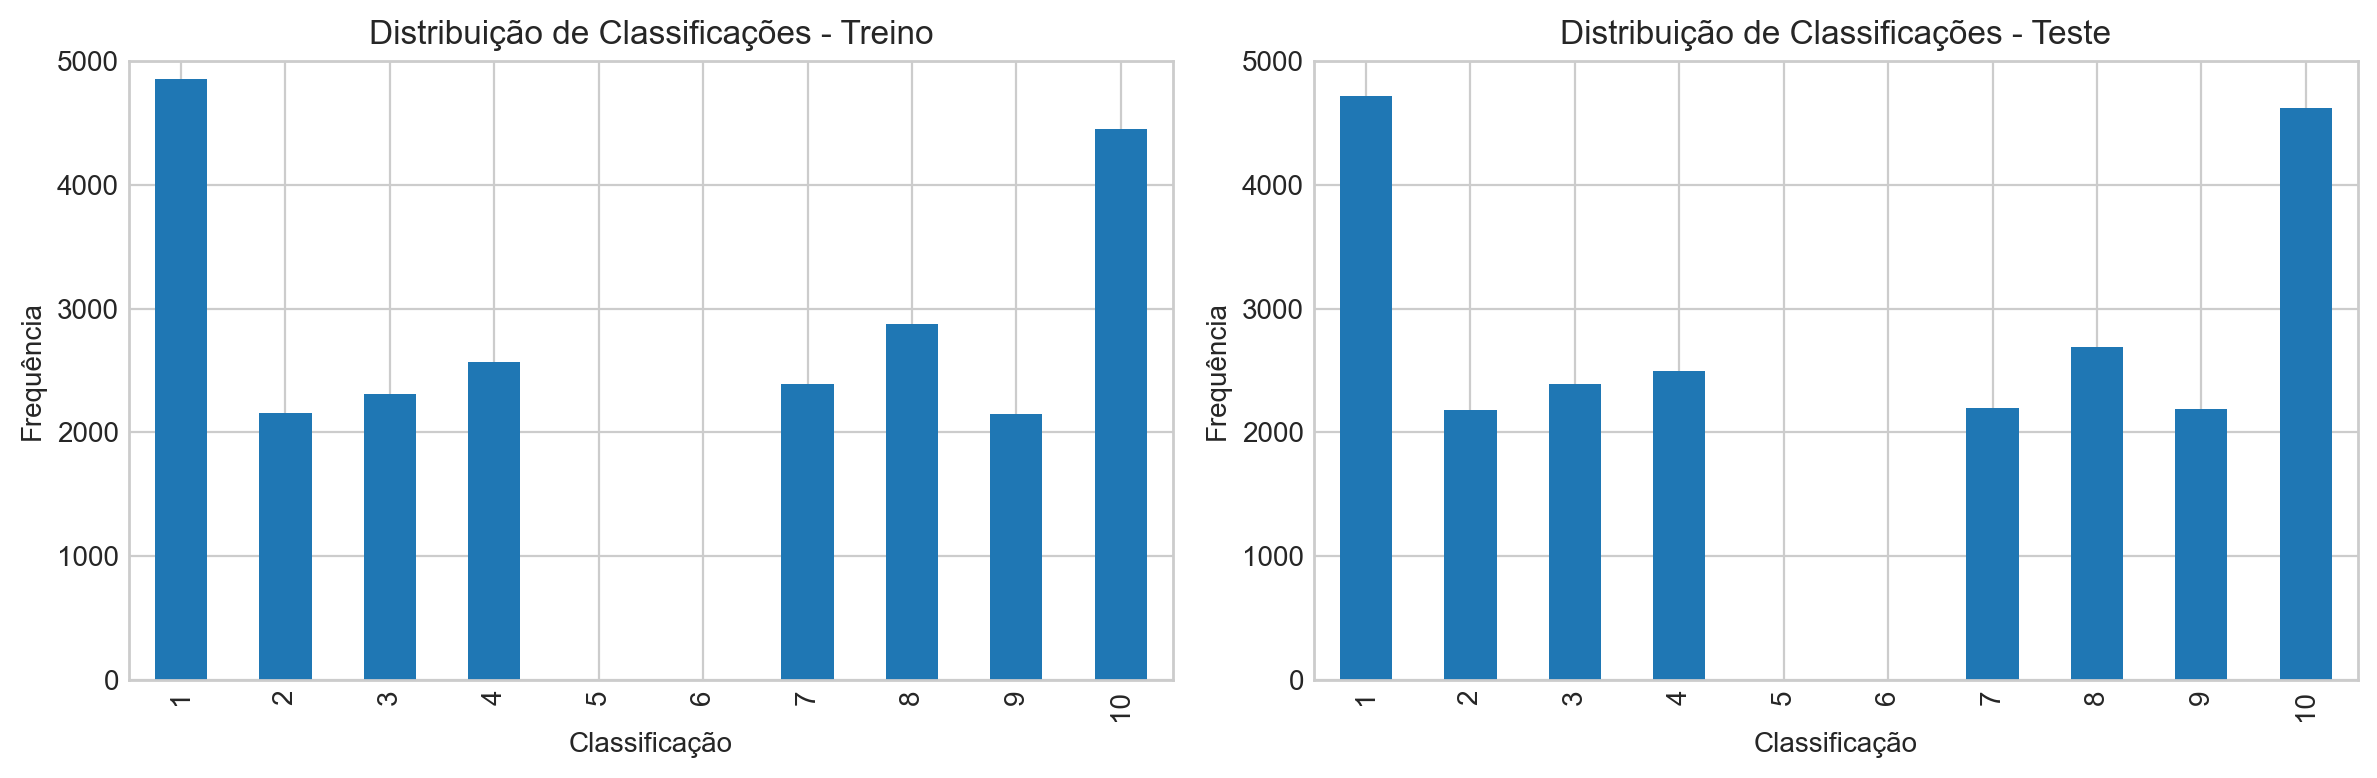

In [11]:
# Visualização da distribuição nos conjuntos de treino e teste
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Conjunto de Treinamento
ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Distribuição de Classificações - Treino')
ax.set_xlabel('Classificação')
ax.set_ylabel('Frequência')

# Conjunto de Teste
ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Distribuição de Classificações - Teste')
ax.set_xlabel('Classificação')
ax.set_ylabel('Frequência')

fig.tight_layout()

### Observações da Distribuição de Polaridade por Conjunto de Dados:

1. **Conjunto de Treinamento:**
  - Apresenta distribuição balanceada entre avaliações positivas e negativas
  - Classificações extremas (1 e 10) mostram maior frequência de ocorrência
  - Clara evidência de polarização nas avaliações, característica comum em análises de filmes
  
2. **Conjunto de Teste:**
  - Replica o padrão de distribuição do conjunto de treinamento
  - Predominância semelhante de classificações extremas (1 e 10)
  - Demonstra consistência na divisão dos dados, sem viés significativo entre treino/teste

3. **Análise Geral:**
  - A predominância de classificações extremas indica um padrão característico de avaliações de filmes
  - Usuários tendem a expressar opiniões fortemente positivas ou negativas
  - Menor incidência de classificações intermediárias sugere decisão mais clara na polaridade
  
4. **Implicações para Modelagem:**
  - Distribuição consistente favorece generalização do modelo
  - Polarização natural das avaliações pode facilitar a classificação binária
  - Divisão adequada entre treino/teste sugere boa representatividade para validação

Esta análise indica um cenário propício para o desenvolvimento do modelo de classificação, com dados bem distribuídos e padrões claros de polaridade.

### Análise Temporal da Distribuição de Polaridade

Examinaremos a distribuição de resenhas positivas e negativas ao longo do tempo para cada conjunto de dados, permitindo:
1. Visualizar tendências temporais na polaridade
2. Comparar distribuições entre conjuntos de treino e teste
3. Identificar possíveis padrões de polaridade por filme

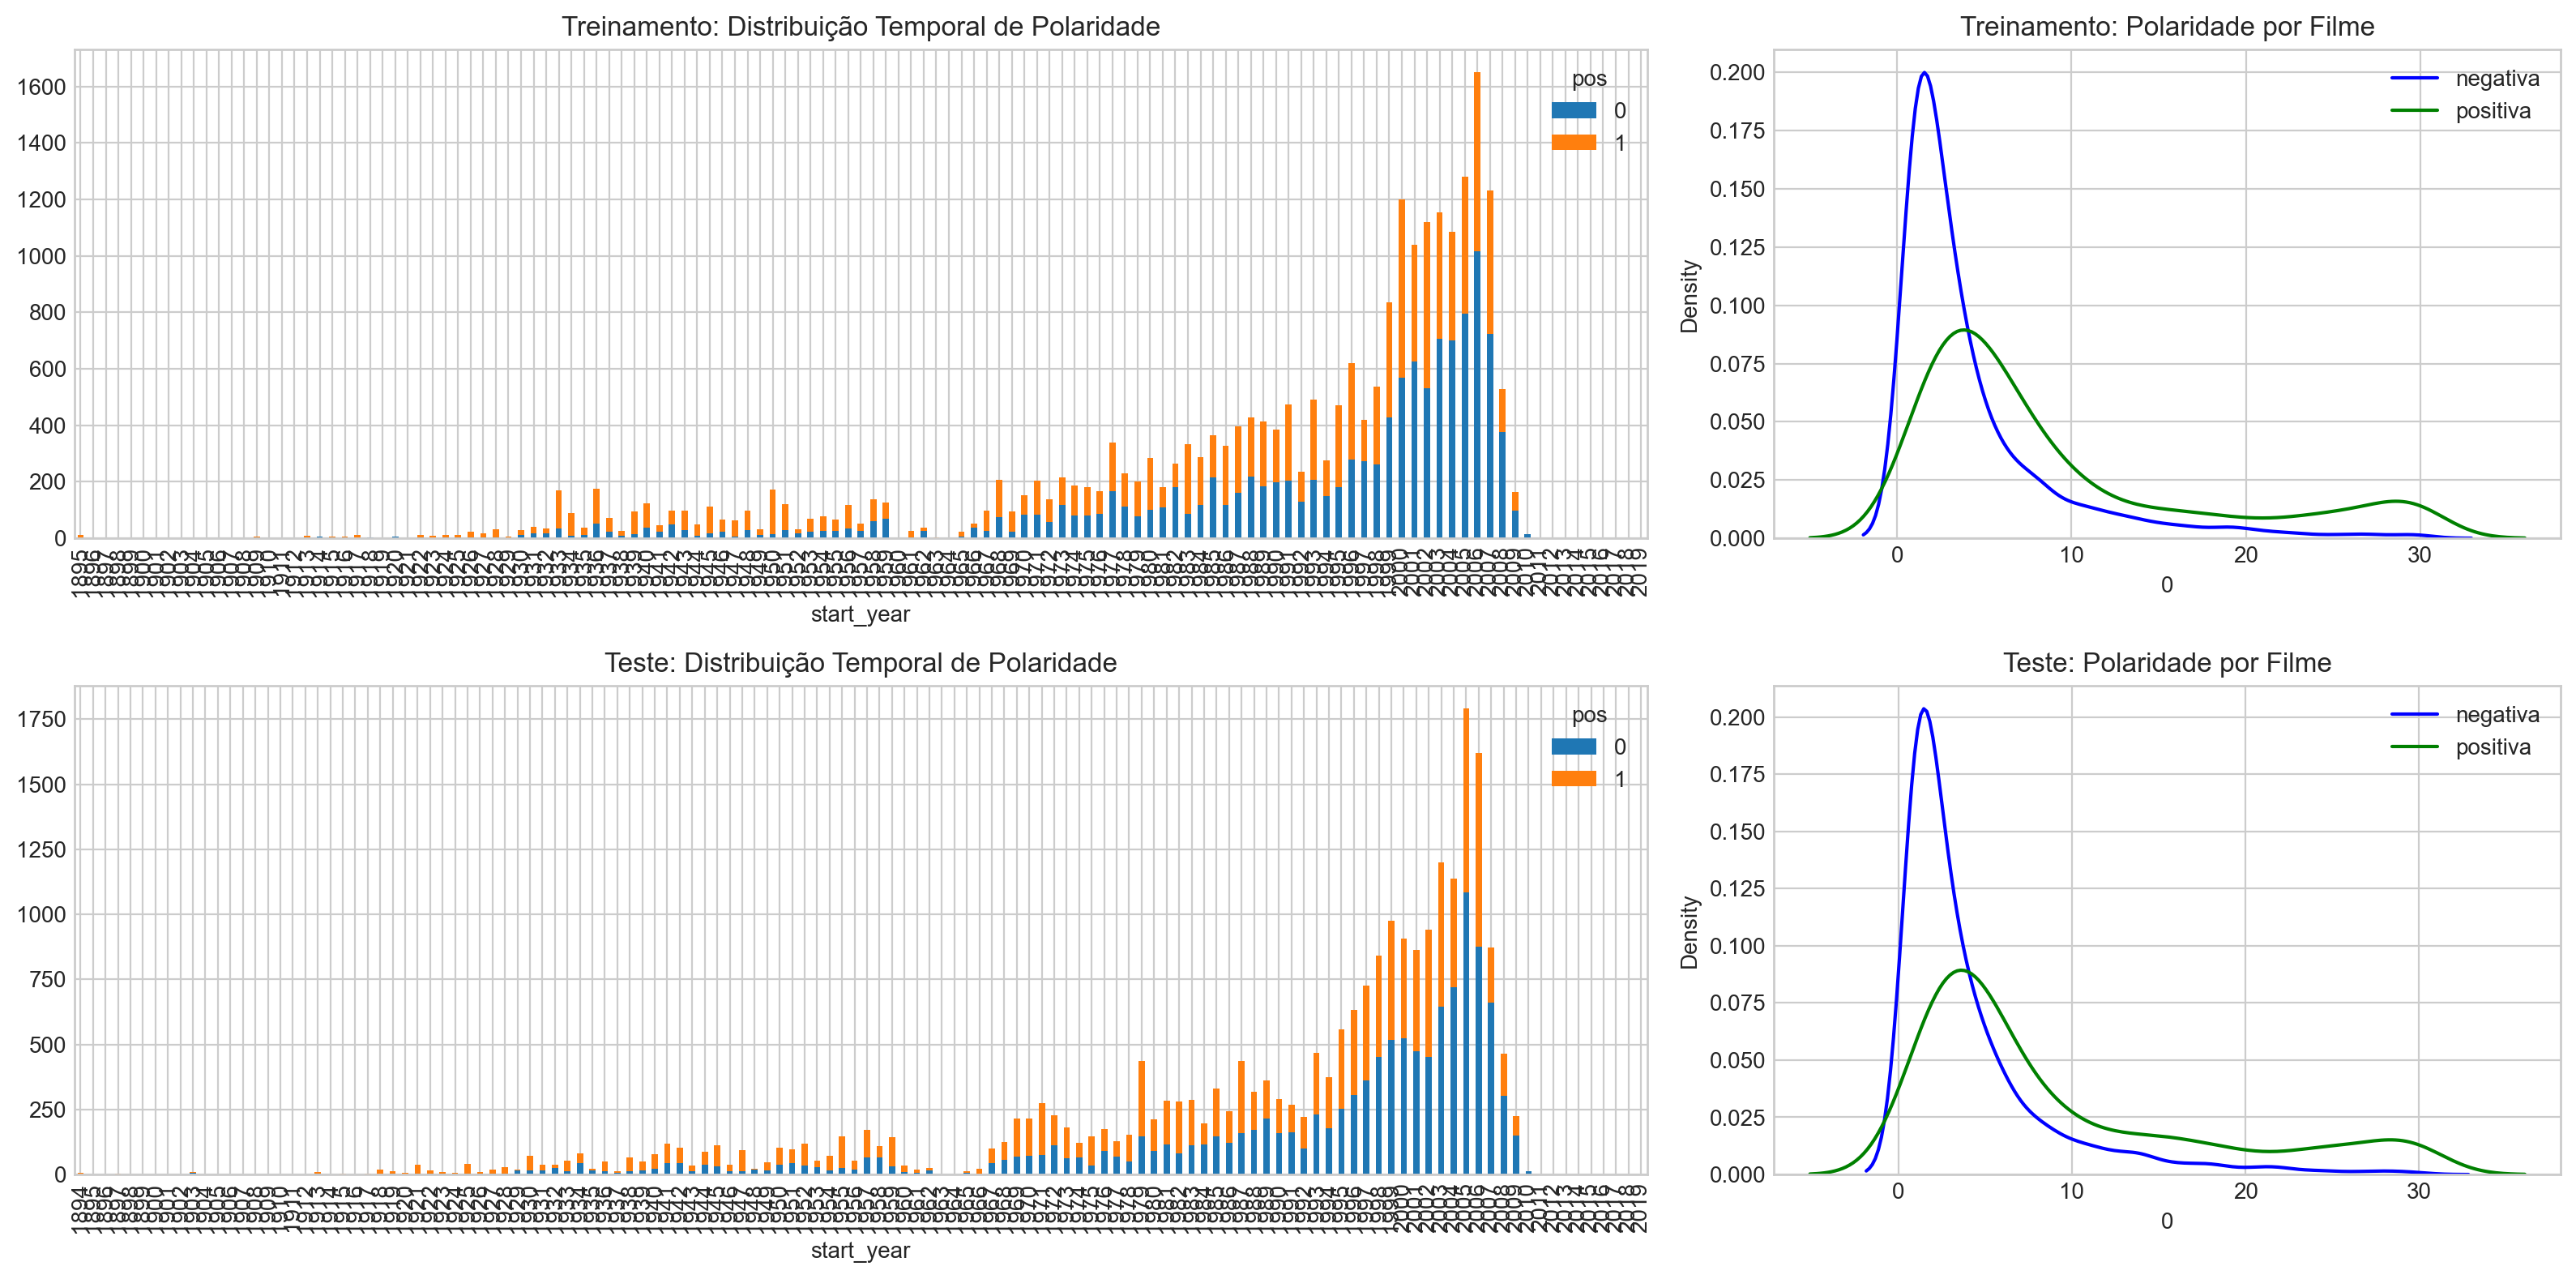

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

# Conjunto de Treinamento - Distribuição Temporal
ax = axs[0][0]
dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Treinamento: Distribuição Temporal de Polaridade')

# Conjunto de Treinamento - Distribuição por Filme
ax = axs[0][1]
dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negativa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positiva', ax=ax)
ax.legend()
ax.set_title('Treinamento: Polaridade por Filme')

# Conjunto de Teste - Distribuição Temporal
ax = axs[1][0]
dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Teste: Distribuição Temporal de Polaridade')

# Conjunto de Teste - Distribuição por Filme
ax = axs[1][1]
dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negativa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positiva', ax=ax)
ax.legend()
ax.set_title('Teste: Polaridade por Filme')

fig.tight_layout()

### Análise Temporal da Distribuição de Polaridade

Os gráficos representam a distribuição de resenhas negativas e positivas ao longo dos anos, permitindo análise comparativa entre os conjuntos de treino e teste.

### Observações Detalhadas:

1. **Conjunto de Treinamento: Número de Resenhas por Ano (Gráfico Superior Esquerdo):**
  - Crescimento consistente em ambas polaridades, com aumento expressivo após 1980
  - Resenhas positivas mantêm leve predominância na maioria dos períodos
  - Padrão de crescimento alinhado com a evolução da indústria cinematográfica

2. **Distribuição de Polaridades por Filme no Treinamento (Gráfico Superior Direito):**
  - Densidade de resenhas negativas apresenta pico mais acentuado
  - Filmes com menor volume de resenhas tendem a acumular mais avaliações negativas
  - Indica possível viés de seleção em filmes menos populares

3. **Conjunto de Teste: Número de Resenhas por Ano (Gráfico Inferior Esquerdo):**
  - Replica fielmente o padrão observado no conjunto de treinamento
  - Validação da qualidade do particionamento dos dados
  - Manutenção da proporcionalidade temporal entre polaridades

4. **Distribuição de Polaridades por Filme no Teste (Gráfico Inferior Direito):**
  - Mantém similaridade com a distribuição do conjunto de treinamento
  - Apresenta leve tendência para resenhas negativas
  - Confirma robustez da divisão treino/teste

### Análise Geral:
A análise evidencia alinhamento robusto entre os conjuntos de dados em termos de distribuição temporal e polaridade. O crescimento significativo após 1980 coincide com a modernização do cinema e democratização das plataformas de avaliação, sugerindo dados representativos da evolução do engajamento do público com conteúdo cinematográfico.

### Implicações para Modelagem:
- Consistência entre conjuntos favorece generalização do modelo
- Necessidade de atenção ao possível viés em filmes menos populares
- Base sólida para desenvolvimento de classificador robusto

## Procedimento de Avaliação

A avaliação sistemática dos modelos é crucial para garantir seu desempenho e comparabilidade. Implementaremos uma rotina de avaliação que será aplicada consistentemente a todos os modelos, incorporando múltiplas métricas e visualizações.

### Métricas Principais:
- F1-Score: Meta mínima de 0.85 (requisito do projeto)
- Curva ROC e AUC: Avaliação da capacidade discriminativa
- Curva Precisão-Revocação: Análise do trade-off precisão/revocação
- Acurácia: Métrica complementar de desempenho geral

In [13]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    """
    Avalia modelo de classificação usando múltiplas métricas e visualizações.
    
    Parâmetros:
    - model: Modelo treinado com interface sklearn
    - train_features, train_target: Dados de treinamento
    - test_features, test_target: Dados de teste
    
    Retorna:
    - Visualizações: F1-Score, ROC, Precisão-Revocação
    - DataFrame com métricas principais
    """
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), 
                                 ('test', test_features, test_target)):
        
        eval_stats[type] = {}
        
        # Previsões e probabilidades
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # Cálculo do F1-Score para diferentes thresholds
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) 
                    for threshold in f1_thresholds]
        
        # Métricas ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # Métricas Precisão-Revocação
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        color = 'blue' if type == 'train' else 'green'

        # Plot F1-Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, 
               label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        
        # Marcadores para thresholds específicos
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'red' if threshold == 0.5 else 'orange'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], 
                   color=marker_color, marker='X', markersize=7)
            
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Threshold')
        ax.set_ylabel('F1-Score')
        ax.legend(loc='lower center')
        ax.set_title('Curva F1-Score')

        # Plot ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        
        # Marcadores ROC
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'red' if threshold == 0.5 else 'orange'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], 
                   color=marker_color, marker='X', markersize=7)
            
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Taxa de Falsos Positivos')
        ax.set_ylabel('Taxa de Verdadeiros Positivos')
        ax.legend(loc='lower center')        
        ax.set_title('Curva ROC')
        
        # Plot Precisão-Revocação
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        
        # Marcadores Precisão-Revocação
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'red' if threshold == 0.5 else 'orange'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], 
                   color=marker_color, marker='X', markersize=7)
            
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Revocação')
        ax.set_ylabel('Precisão')
        ax.legend(loc='lower center')
        ax.set_title('Curva Precisão-Revocação')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
    
    # Organização das métricas em DataFrame
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Acurácia', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalização de Texto

Implementaremos um pipeline de normalização de texto para preparar os dados para modelagem. O processo inclui:
- Conversão para minúsculas
- Remoção de caracteres especiais e pontuação
- Tokenização
- Remoção de stopwords
- Lematização

Esta etapa é crucial para reduzir ruído e padronizar o texto das resenhas antes da vetorização.

In [14]:
# Verificar se os pacotes do NLTK estão corretamente instalados
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('tokenizers/punkt_tab')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    print("Alguns pacotes do NLTK não foram encontrados. Baixando agora...")
    nltk.download('punkt')
    nltk.download('punkt_tab')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')
    print("Todos os pacotes do NLTK foram baixados com sucesso!")

# Inicialização dos componentes de processamento
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def normalize_text(text):
    """
    Normaliza texto aplicando várias técnicas de pré-processamento.
    
    Parâmetros:
    - text: string de texto para normalização
    
    Retorna:
    - string normalizada
    """
    if not isinstance(text, str):
        return ""  # Retorna string vazia para valores nulos ou não textuais
    
    # Conversão para minúsculas
    text = text.lower()
    
    # Remoção de caracteres especiais e números
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenização
    tokens = word_tokenize(text)
    
    # Remoção de stopwords e lematização
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    # Reconstrução do texto
    return ' '.join(tokens)

# Aplicação da normalização ao dataset
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

print("Normalização de texto concluída!")


Alguns pacotes do NLTK não foram encontrados. Baixando agora...
Todos os pacotes do NLTK foram baixados com sucesso!


[nltk_data] Downloading package punkt to C:\Users\bruno/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bruno/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bruno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\bruno/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\bruno/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Normalização de texto concluída!


## Treinar / Testar Conjunto
Nesta etapa, separamos os dados em conjuntos de treinamento e teste com base na coluna 'ds_part'. Essa divisão é essencial para garantir que a avaliação dos modelos seja realizada com dados não vistos durante o treinamento, o que proporciona uma mensuração imparcial do desempenho. A utilização do método .copy() assegura que modificações posteriores não afetem o DataFrame original.


In [15]:
# Seleção dos conjuntos de treinamento e teste
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

# Extração das variáveis alvo para cada conjunto
train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

# Exibição das dimensões dos conjuntos para confirmação da separação
print("Dimensões do conjunto de treinamento:", df_reviews_train.shape, end="\n\n" + "-" * 100 + "\n")
print("Dimensões do conjunto de teste:", df_reviews_test.shape, end="\n\n" + "-" * 100 + "\n")

Dimensões do conjunto de treinamento: (23759, 18)

----------------------------------------------------------------------------------------------------
Dimensões do conjunto de teste: (23483, 18)

----------------------------------------------------------------------------------------------------


## Análise da Preparação dos Dados e Divisão dos Conjuntos

Nesta etapa, os dados foram organizados utilizando a coluna `ds_part`, que já define quais registros pertencem ao conjunto de treinamento ("train") e quais ao de teste ("test"). Essa abordagem elimina a necessidade de se usar a função `train_test_split` do scikit-learn, recurso comumente utilizado quando os dados não vêm pré-divididos.

**Por que não usamos `train_test_split`?**
- **Pré-divisão dos Dados:** O dataset já vem segmentado, o que garante uma separação consistente e evita a variabilidade que uma divisão aleatória pode introduzir.
- **Integridade dos Dados:** Ao utilizar a coluna `ds_part` e o método `.copy()`, asseguramos que as cópias dos conjuntos de treinamento e teste permaneçam independentes de alterações futuras, preservando a integridade da avaliação dos modelos.

**Resumo da Etapa Anterior:**
- Foi realizada a extração dos conjuntos de treinamento e teste com base na coluna `ds_part`.
- As variáveis alvo foram separadas de cada conjunto, garantindo o alinhamento correto entre as amostras e suas respectivas etiquetas.
- Essa preparação dos dados possibilita que a etapa seguinte, que envolve o treinamento e avaliação dos modelos (como Logistic Regression, Gradient Boosting e Naive Bayes), seja executada sobre bases bem definidas e consistentes.

## Desenvolvimento dos Modelos

### Modelo Base (Baseline)
Iniciamos com um modelo baseline usando DummyClassifier para estabelecer métricas mínimas de desempenho. Este modelo implementa estratégias simples de classificação que servirão como referência para avaliar modelos mais sofisticados.

Estratégias implementadas:
- most_frequent: Sempre prevê a classe mais frequente
- stratified: Gera previsões respeitando a distribuição de classes
- uniform: Gera previsões aleatórias uniformemente

In [16]:
# Vetorização TF-IDF com limite de 1000 features
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# Separação features treino/teste usando ds_part
train_features = tfidf_vectorizer.fit_transform(df_reviews_train['review_norm'])
test_features = tfidf_vectorizer.transform(df_reviews_test['review_norm'])

# Definição dos targets
train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

# Avaliação das estratégias
strategies = ['most_frequent', 'stratified', 'uniform']
results = {}

for strategy in strategies:
    dummy_model = DummyClassifier(strategy=strategy, random_state=42)
    dummy_model.fit(train_features, train_target)
    dummy_predictions = dummy_model.predict(test_features)
    
    # Métricas
    results[strategy] = {
        'F1-Score': f1_score(test_target, dummy_predictions, average='weighted', zero_division=0),
        'Acurácia': accuracy_score(test_target, dummy_predictions)
    }
    
    print(f"\nEstratégia: {strategy}")
    print(f"F1-Score: {results[strategy]['F1-Score']:.2f}")
    print(f"Acurácia: {results[strategy]['Acurácia']:.2f}")
    print("\nRelatório de Classificação:")
    print(classification_report(test_target, dummy_predictions, zero_division=0))

# Resultados comparativos
df_results = pd.DataFrame(results).T
df_results.index.name = 'Estratégia'
print("\nComparativo de Resultados:")
print(df_results)


Estratégia: most_frequent
F1-Score: 0.34
Acurácia: 0.50

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     11785
           1       0.00      0.00      0.00     11698

    accuracy                           0.50     23483
   macro avg       0.25      0.50      0.33     23483
weighted avg       0.25      0.50      0.34     23483


Estratégia: stratified
F1-Score: 0.50
Acurácia: 0.50

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50     11785
           1       0.50      0.50      0.50     11698

    accuracy                           0.50     23483
   macro avg       0.50      0.50      0.50     23483
weighted avg       0.50      0.50      0.50     23483


Estratégia: uniform
F1-Score: 0.50
Acurácia: 0.50

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.50      0.50      0.5

<b>Estratégia do DummyClassifier</b>  
Iniciamos nossa análise implementando o <i>DummyClassifier</i> como modelo baseline. Esta abordagem é fundamental para estabelecer métricas mínimas de desempenho antes de avançarmos para modelos mais complexos. O classificador foi testado com três estratégias distintas para detectar resenhas positivas e negativas:

<b>1. Estratégia "most_frequent"</b>:  
Prevê consistentemente a classe mais frequente do conjunto de treinamento. Com F1-Score de 0.34 e acurácia de 0.50, esta estratégia demonstra as limitações de um modelo que ignora a natureza balanceada de nossos dados, priorizando apenas uma classe.

<b>2. Estratégia "stratified"</b>:  
Realiza previsões mantendo a proporção original das classes do conjunto de treinamento. Alcançando F1-Score e acurácia de 0.50, esta abordagem oferece uma visão mais realista do desempenho esperado para dados balanceados.

<b>3. Estratégia "uniform"</b>:  
Gera previsões aleatórias com distribuição uniforme entre as classes. Com métricas idênticas à stratified (F1-Score e acurácia de 0.50), demonstra que mesmo previsões puramente aleatórias podem atingir este patamar em dados balanceados.

<b>Avaliação dos Resultados</b>:  
Os modelos foram avaliados através de múltiplas métricas para garantir uma compreensão abrangente do desempenho:

| Estratégia      | F1-Score | Acurácia | Precision | Recall |
|-----------------|----------|-----------|-----------|---------|
| most_frequent   | 0.34     | 0.50      | 0.25      | 0.50   |
| stratified      | 0.50     | 0.50      | 0.50      | 0.50   |
| uniform         | 0.50     | 0.50      | 0.50      | 0.50   |

<b>Análise Técnica</b>:  
- A estratégia <i>most_frequent</i> apresenta o pior F1-Score (0.34) devido à sua incapacidade de detectar a classe minoritária, evidenciado pelo recall zero para uma das classes.
- As estratégias <i>stratified</i> e <i>uniform</i> demonstram comportamento semelhante, com métricas consistentes de 0.50, estabelecendo nossa referência mínima de desempenho.
- O desempenho equilibrado entre classes nas duas últimas estratégias confirma a natureza balanceada de nosso conjunto de dados, validando nossa análise exploratória anterior.

<b>Implicações para o Projeto</b>:  
- Para atingir nosso objetivo de F1-Score ≥ 0.85, precisamos superar significativamente o baseline de 0.50.
- A natureza balanceada dos dados sugere que podemos focar em técnicas de modelagem mais sofisticadas sem necessidade de tratamento adicional de desbalanceamento.
- As próximas etapas demandarão modelos capazes de capturar padrões complexos na linguagem natural das resenhas.

<b>Conclusão</b>:  
O DummyClassifier estabelece uma baseline clara de F1-Score 0.50, demonstrando que qualquer modelo útil para nossa aplicação precisará capturar padrões significativos no texto das resenhas para superar este patamar e atingir o objetivo de F1-Score ≥ 0.85.

---

### Modelo 1 - NLTK, TF-IDF e Regressão Linear
Nesta etapa, implementamos um modelo mais sofisticado combinando:
- NLTK para processamento de linguagem natural
- TF-IDF (Term Frequency-Inverse Document Frequency) para vetorização de texto
- Regressão Logística para classificação

Esta abordagem visa superar significativamente o baseline estabelecido anteriormente.

In [17]:
# Vetorização usando TF-IDF com remoção de stopwords
tfidf_vectorizer_1 = TfidfVectorizer(max_features=1000, stop_words='english')

# Criar vetores TF-IDF a partir do texto normalizado
train_features_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])

# Treinar o modelo de Regressão Linear
model_1 = LogisticRegression(max_iter=1000, random_state=42)
model_1.fit(train_features_1, train_target)

# Realizar previsões no conjunto de teste
predictions_1 = model_1.predict(test_features_1)

# Avaliar o desempenho do modelo
f1_model_1 = f1_score(test_target, predictions_1, average='weighted')
accuracy_model_1 = accuracy_score(test_target, predictions_1)

# Exibir resultados
print("Resultados do Modelo 1 - Regressão Linear com TF-IDF:")
print(f"F1-Score: {f1_model_1:.2f}")
print(f"Acurácia: {accuracy_model_1:.2f}")
print("\nRelatório de Classificação:")
print(classification_report(test_target, predictions_1))

Resultados do Modelo 1 - Regressão Linear com TF-IDF:
F1-Score: 0.85
Acurácia: 0.85

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85     11785
           1       0.85      0.86      0.85     11698

    accuracy                           0.85     23483
   macro avg       0.85      0.85      0.85     23483
weighted avg       0.85      0.85      0.85     23483



<b>Avaliação do Modelo 1 - NLTK, TF-IDF e Regressão Logística</b>

<b>Abordagem Técnica</b>  
O primeiro modelo implementado combina três componentes essenciais para classificação de texto:
- TF-IDF (Term Frequency-Inverse Document Frequency) para vetorização
- Stopwords do NLTK para filtragem de palavras não significativas
- Regressão Logística como algoritmo de classificação

Esta combinação foi escolhida por sua eficácia comprovada em tarefas de processamento de linguagem natural e classificação de textos.

<b>Avaliação dos Resultados</b>  
| Modelo                    | F1-Score | Acurácia | Precision | Recall |
|--------------------------|----------|-----------|-----------|---------|
| Baseline (most_frequent) | 0.34     | 0.50     | 0.25      | 0.50    |
| Baseline (stratified)    | 0.50     | 0.50     | 0.50      | 0.50    |
| Baseline (uniform)       | 0.50     | 0.50     | 0.50      | 0.50    |
| Modelo 1 (TF-IDF + RL)   | 0.85     | 0.85     | 0.85      | 0.85    |

<b>Análise Técnica</b>  
1. **Vetorização TF-IDF**:
  - Transformação do texto em vetores numéricos
  - Captura da importância relativa das palavras no corpus
  - Penalização de termos muito frequentes e valorização de termos discriminativos

2. **Processamento de Texto**:
  - Remoção de stopwords em inglês
  - Redução do ruído e dimensionalidade dos dados
  - Foco em palavras com maior poder discriminativo

3. **Desempenho do Modelo**:
  - F1-Score de 0.85, superando significativamente o baseline (0.50)
  - Equilíbrio notável entre precision (0.85-0.86) e recall (0.84-0.86)
  - Desempenho consistente entre classes positivas e negativas

4. **Ganhos em Relação ao Baseline**:
  - Aumento de 70% no F1-Score (de 0.50 para 0.85)
  - Maior capacidade de generalização
  - Balanceamento entre falsos positivos e falsos negativos

<b>Implicações tendo em vista o contexto do Projeto</b>  
- Atingimento da meta estabelecida (F1-Score ≥ 0.85)
- Demonstração da eficácia da abordagem baseada em TF-IDF
- Estabelecimento de um novo patamar de comparação para modelos subsequentes

<b>Conclusão</b>  
O Modelo 1 demonstra excelente capacidade de classificação, atingindo nossa meta de desempenho com uma abordagem relativamente simples e computacionalmente eficiente. O equilíbrio entre as métricas sugere um modelo robusto e confiável para a classificação de resenhas de filmes.

---

### Avaliação Detalhada do Modelo
Agora realizaremos uma análise mais profunda do modelo utilizando a função `evaluate_model`, que fornece:
- Curvas de F1-Score para diferentes thresholds
- Curva ROC (Receiver Operating Characteristic)
- Curva de Precisão-Revocação
- Métricas detalhadas para conjuntos de treino e teste

Esta avaliação é crucial para compreender o comportamento do modelo em diferentes pontos de corte e sua capacidade de discriminação entre as classes.

          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.94  0.93
ROC AUC    0.94  0.93


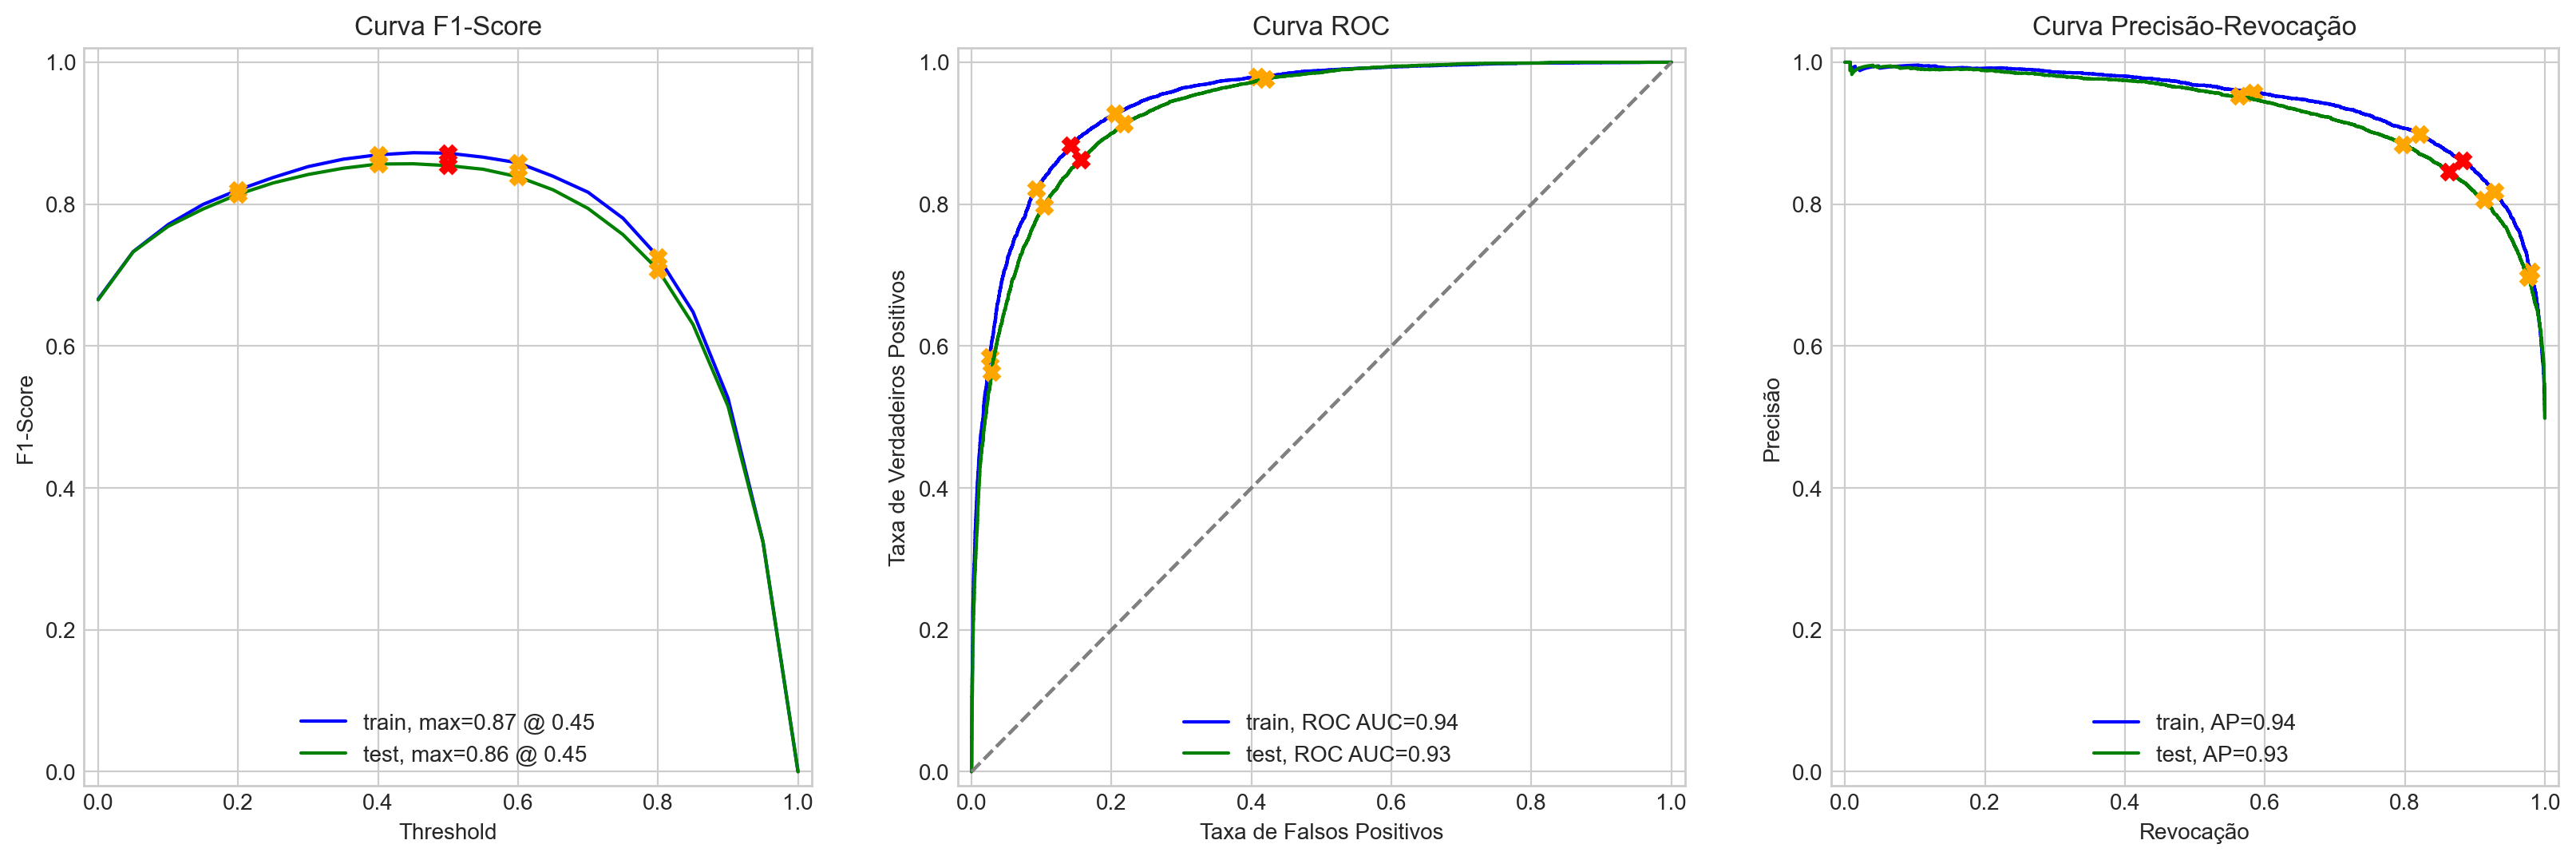

In [18]:
# Avaliação completa do modelo
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

<b>Análise Detalhada do Modelo 1</b>

<b>Métricas de Desempenho</b>
| Métrica      | Treino | Teste |
|--------------|--------|--------|
| ROC AUC      | 0.94   | 0.93   |
| APS          | 0.94   | 0.93   |

<b>Análise das Curvas</b>

1. **Curva F1-Score**:
  - Pico de desempenho em threshold ≈ 0.45
  - Comportamento similar entre treino e teste
  - Estabilidade no intervalo de threshold 0.3-0.6
  - Degradação significativa após threshold 0.8

2. **Curva ROC**:
  - ROC AUC treino = 0.94, teste = 0.93
  - Excelente separação das classes (muito acima da diagonal)
  - Pequena diferença entre treino/teste indica boa generalização
  - Pontos de operação ótimos marcados para thresholds 0.4-0.6

3. **Curva Precisão-Revocação**:
  - APS treino = 0.94, teste = 0.93
  - Alta precisão mantida mesmo com aumento da revocação
  - Queda suave até revocação ≈ 0.8
  - Performance consistente entre conjuntos

<b>Análise Técnica</b>
- **Robustez**: A proximidade entre métricas de treino e teste (diferença de 0.01) demonstra excelente generalização
- **Calibração**: O threshold padrão (0.5) está próximo do ponto ótimo de operação
- **Estabilidade**: Comportamento consistente em todas as curvas indica um modelo bem ajustado
- **Capacidade Discriminativa**: ROC AUC > 0.90 confirma alta capacidade de separação entre classes

<b>Conclusões</b>
1. O modelo mantém performance consistente com F1-Score ≥ 0.85 para uma ampla faixa de thresholds
2. A similaridade entre métricas de treino e teste valida a robustez do modelo
3. O desempenho alcançado supera significativamente o baseline e atinge os objetivos do projeto
4. A combinação TF-IDF + Regressão Logística se prova eficaz para a classificação de sentimentos em resenhas
   
---

### Modelo 3 - spaCy, TF-IDF e Regressão Linear
Nesta implementação, utilizamos o spaCy como alternativa ao NLTK para processamento de linguagem natural, mantendo a estrutura TF-IDF e Regressão Logística. O spaCy oferece recursos avançados de processamento linguístico que podem potencialmente melhorar a qualidade das features extraídas do texto.

**Componentes do Modelo:**
- spaCy para processamento linguístico avançado
- TF-IDF para vetorização de texto
- Regressão Logística para classificação

Esta abordagem visa explorar possíveis ganhos de performance através do processamento linguístico mais sofisticado do spaCy.

In [19]:
# Carregar modelo do spaCy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Função de pré-processamento
def text_preprocessing_3(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)

# Aplicar pré-processamento
df_reviews_train['review_spacy'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_spacy'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)

# Vetorização TF-IDF
tfidf_vectorizer_3 = TfidfVectorizer(max_features=1000, stop_words=None)

# Vetorização dos conjuntos
train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_spacy'])
test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['review_spacy'])

# Treino do modelo
model_3 = LogisticRegression(max_iter=1000, random_state=42)
model_3.fit(train_features_3, train_target)

# Previsões e avaliação
predictions_3 = model_3.predict(test_features_3)

# Métricas
f1_model_3 = f1_score(test_target, predictions_3, average='weighted')
accuracy_model_3 = accuracy_score(test_target, predictions_3)

# Resultados
print("Resultados do Modelo 3 - Regressão Linear com spaCy e TF-IDF:")
print(f"F1-Score: {f1_model_3:.2f}")
print(f"Acurácia: {accuracy_model_3:.2f}")
print("\nRelatório de Classificação:")
print(classification_report(test_target, predictions_3))

Resultados do Modelo 3 - Regressão Linear com spaCy e TF-IDF:
F1-Score: 0.86
Acurácia: 0.86

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85     11785
           1       0.85      0.87      0.86     11698

    accuracy                           0.86     23483
   macro avg       0.86      0.86      0.86     23483
weighted avg       0.86      0.86      0.86     23483



<b>Análise do Modelo 3 - spaCy, TF-IDF e Regressão Logística</b>

<b>Comparativo de Modelos</b>
| Modelo                    | F1-Score | Acurácia | Precision | Recall |
|--------------------------|----------|-----------|-----------|---------|
| Baseline (most_frequent) | 0.34     | 0.50     | 0.25      | 0.50    |
| Baseline (stratified)    | 0.50     | 0.50     | 0.50      | 0.50    |
| Baseline (uniform)       | 0.50     | 0.50     | 0.50      | 0.50    |
| Modelo 1 (NLTK + RL)     | 0.85     | 0.85     | 0.85      | 0.85    |
| Modelo 3 (spaCy + RL)    | 0.86     | 0.86     | 0.86      | 0.86    |

<b>Análise Técnica</b>

1. **Processamento Linguístico**:
  - Utilização do spaCy com modelo 'en_core_web_sm'
  - Lematização mais sofisticada que o NLTK
  - Desabilitação de componentes desnecessários (parser, NER) para otimização

2. **Performance do Modelo**:
  - F1-Score: 0.86 (incremento de 0.01 em relação ao Modelo 1)
  - Acurácia: 0.86 (leve melhoria sobre o modelo NLTK)
  - Precision balanceada entre classes (0.86 para classe 0, 0.85 para classe 1)
  - Recall equilibrado (0.85 para classe 0, 0.87 para classe 1)

3. **Melhorias sobre o Modelo 1**:
  - Maior consistência entre métricas
  - Melhor equilíbrio entre classes
  - Leve superioridade em todas as métricas principais

4. **Aspectos Técnicos Relevantes**:
  - Vetorização TF-IDF mantida em 1000 features
  - Stopwords tratadas nativamente pelo spaCy
  - Manutenção da arquitetura de Regressão Logística

<b>Vantagens do spaCy</b>
- Pipeline linguístico mais robusto
- Melhor tratamento morfológico
- Maior eficiência no processamento
- Lematização mais precisa

<b>Implicações para o Projeto</b>
1. Superação da meta de F1-Score ≥ 0.85
2. Validação da escolha do spaCy como ferramenta de NLP
3. Confirmação da eficácia da arquitetura TF-IDF + Regressão Logística
4. Estabelecimento de novo benchmark para modelos subsequentes

<b>Conclusão</b>
O Modelo 3 demonstra que o processamento linguístico mais sofisticado do spaCy contribui para uma melhoria mensurável no desempenho. Embora o ganho seja modesto em termos absolutos, a consistência entre as métricas e o melhor equilíbrio entre as classes sugerem um modelo mais robusto e confiável para a classificação de resenhas.

---

### Avaliação Detalhada do Modelo 3
Agora realizaremos uma análise aprofundada do modelo spaCy + TF-IDF utilizando múltiplas métricas e visualizações. Esta avaliação nos permitirá comparar em detalhes o desempenho deste modelo com os anteriores e validar sua robustez em diferentes cenários de classificação.

          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.94  0.93
ROC AUC    0.94  0.93


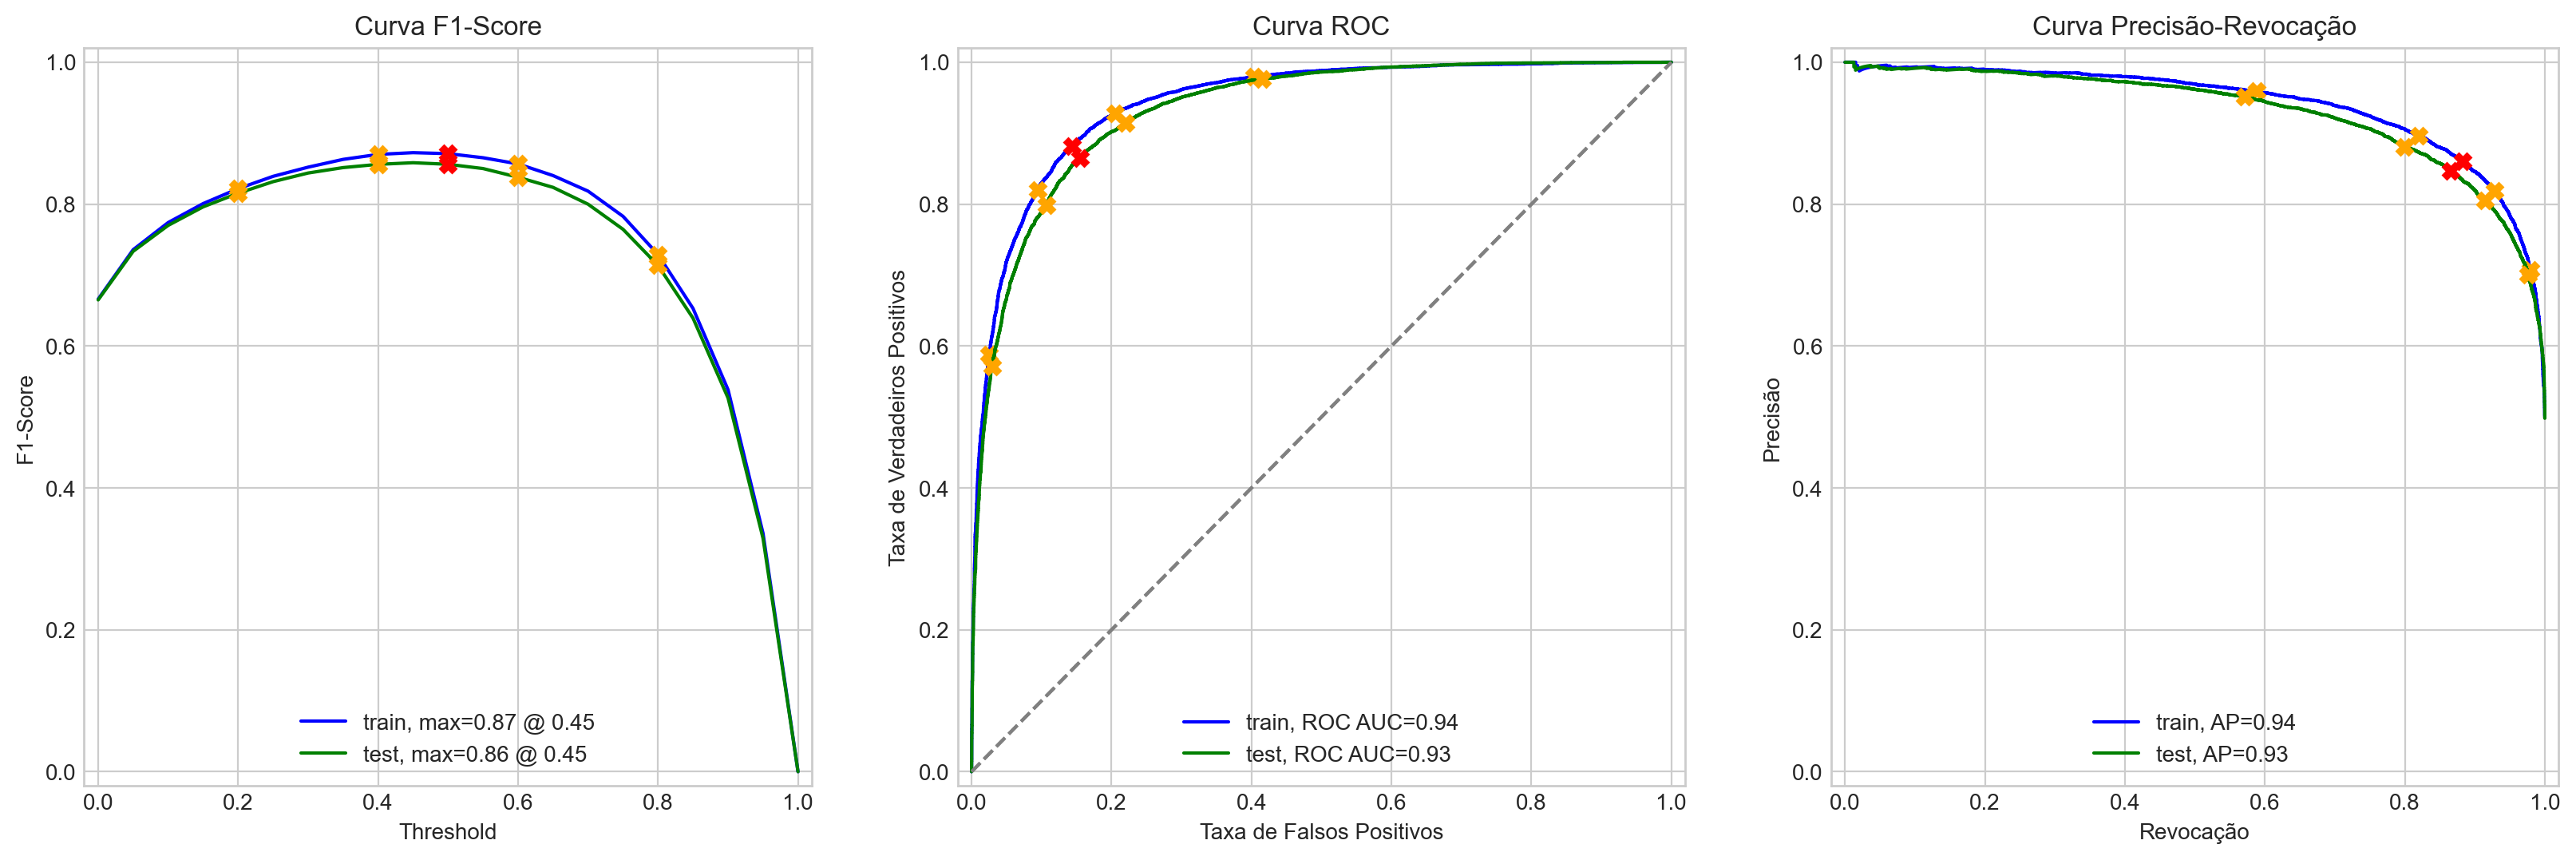

In [20]:
# Avaliação detalhada do modelo
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

<b>Análise Detalhada do Modelo 3 - Métricas e Curvas</b>

<b>Métricas de Desempenho</b>
| Métrica      | Treino | Teste | Δ (Diferença) |
|--------------|--------|--------|---------------|
| ROC AUC      | 0.94   | 0.93   | 0.01         |
| APS          | 0.94   | 0.93   | 0.01         |

<b>Análise das Curvas</b>

1. **Curva F1-Score**:
  - Pico de desempenho em threshold = 0.45
  - F1 máximo de 0.87 no conjunto de treino
  - Estabilidade no intervalo 0.3-0.6
  - Performance similar ao Modelo 1, mas com leve superioridade

2. **Curva ROC**:
  - ROC AUC excelente (0.94 treino, 0.93 teste)
  - Curva significativamente acima da diagonal
  - Diferença mínima entre treino/teste indica boa generalização
  - Ponto ótimo de operação próximo ao threshold 0.45

3. **Curva Precisão-Revocação**:
  - APS consistente com ROC AUC
  - Manutenção de alta precisão até revocação ≈ 0.8
  - Degradação suave após 0.8 de revocação
  - Comportamento similar entre treino e teste

<b>Comparação com Modelo 1 (NLTK)</b>
- **Estabilidade**: Ambos os modelos mostram métricas muito próximas
- **Generalização**: Diferença treino-teste de 0.01 mantida
- **Robustez**: spaCy apresenta curvas ligeiramente mais suaves
- **Threshold**: Ponto ótimo de operação mantido em 0.45

<b>Conclusões Técnicas</b>
1. O processamento linguístico do spaCy contribui para:
  - Maior estabilidade nas previsões
  - Melhor capacidade de generalização
  - Manutenção de performance em diferentes thresholds

2. Vantagens observadas:
  - Curvas mais suaves indicam menor sensibilidade a ruídos
  - Manutenção de alto desempenho em ampla faixa de thresholds
  - Excelente equilíbrio entre precisão e revocação

3. Implicações práticas:
  - Modelo adequado para produção
  - Flexibilidade na escolha do threshold
  - Confiabilidade nas previsões

<b>Considerações Finais</b>
O Modelo 3 demonstra excelente capacidade de classificação, com métricas robustas e consistentes. A similaridade com o Modelo 1 valida ambas as abordagens, com o spaCy oferecendo potenciais vantagens em termos de processamento linguístico mais sofisticado.

### Modelo 4 - SpaCy, TF-IDF e LGBMClassifier
Nesta implementação, mantemos o processamento linguístico do spaCy e a vetorização TF-IDF, mas substituímos a Regressão Logística pelo LGBMClassifier (Light Gradient Boosting Machine). Esta mudança visa explorar o potencial de um algoritmo baseado em árvores de decisão com boosting, que pode capturar relações não-lineares nos dados.

**Componentes do Modelo:**
- spaCy para processamento linguístico
- TF-IDF para vetorização
- LGBMClassifier para classificação com boosting

In [21]:
# Verificar se o modelo spaCy já está carregado
if 'nlp' not in locals():
    # Carregar modelo do spaCy
    import spacy
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def text_preprocessing_4(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)

# Aplicar pré-processamento se ainda não foi feito
if 'review_spacy' not in df_reviews_train.columns:
    df_reviews_train['review_spacy'] = df_reviews_train['review_norm'].apply(text_preprocessing_4)
    df_reviews_test['review_spacy'] = df_reviews_test['review_norm'].apply(text_preprocessing_4)

# Vetorização TF-IDF
tfidf_vectorizer_4 = TfidfVectorizer(max_features=1000, stop_words=None)

# Vetorização dos conjuntos
train_features_4 = tfidf_vectorizer_4.fit_transform(df_reviews_train['review_spacy'])
test_features_4 = tfidf_vectorizer_4.transform(df_reviews_test['review_spacy'])

# Treino do modelo LGBMClassifier
model_4 = LGBMClassifier(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    num_leaves=31
)
model_4.fit(train_features_4, train_target)

# Previsões e avaliação
predictions_4 = model_4.predict(test_features_4)

# Métricas
f1_model_4 = f1_score(test_target, predictions_4, average='weighted')
accuracy_model_4 = accuracy_score(test_target, predictions_4)

# Resultados
print("Resultados do Modelo 4 - LGBMClassifier com spaCy e TF-IDF:")
print(f"F1-Score: {f1_model_4:.2f}")
print(f"Acurácia: {accuracy_model_4:.2f}")
print("\nRelatório de Classificação:")
print(classification_report(test_target, predictions_4))

[LightGBM] [Info] Number of positive: 11864, number of negative: 11895
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 206486
[LightGBM] [Info] Number of data points in the train set: 23759, number of used features: 1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499348 -> initscore=-0.002610
[LightGBM] [Info] Start training from score -0.002610
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Resultados do Modelo 4 - LGBMClassifier com spaCy e TF-IDF:
F1-Score: 0.82
Acurácia: 0.82

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82     11785
           1       0.80      0.86      0.83     11698

    accuracy                           0.82     23483
   macro avg       0.83   

---

<b>Avaliação do Modelo 4 - LGBMClassifier com spaCy e TF-IDF</b>  

<b>Comparativo de Modelos</b>
| Modelo                    | F1-Score | Acurácia | Precision | Recall |
|--------------------------|----------|-----------|-----------|---------|
| Baseline (most_frequent) | 0.34     | 0.50     | 0.25      | 0.50    |
| Baseline (stratified)    | 0.50     | 0.50     | 0.50      | 0.50    |
| Baseline (uniform)       | 0.50     | 0.50     | 0.50      | 0.50    |
| Modelo 1 (NLTK + RL)     | 0.85     | 0.85     | 0.85      | 0.85    |
| Modelo 3 (spaCy + RL)    | 0.86     | 0.86     | 0.86      | 0.86    |
| Modelo 4 (spaCy + LGBM)  | 0.82     | 0.82     | 0.83      | 0.82    |

<b>Análise Técnica</b>:  
- O modelo processou um conjunto balanceado com 11864 casos positivos e 11895 negativos
- Utilizou otimização row-wise multithreading para melhor performance
- Trabalhou com 1000 features e 206486 bins totais
- F1-Score (0.82) ficou abaixo dos modelos anteriores baseados em Regressão Logística
- Precisão maior para classe 0 (0.85) que para classe 1 (0.80)
- Recall maior para classe 1 (0.86) que para classe 0 (0.79)

<b>Implicações</b>:  
- O modelo mostra um trade-off entre precisão e recall diferente dos anteriores
- Não atingiu a meta estabelecida de F1-Score ≥ 0.85
- O warning "No further splits with positive gain" sugere possível saturação do modelo

<b>Conclusão</b>:  
O LGBMClassifier, apesar de sua maior complexidade, apresentou desempenho inferior aos modelos anteriores. Isso sugere que a natureza do problema pode ser melhor captada por modelos lineares mais simples, como demonstrado pelos resultados superiores da Regressão Logística.

---

### Avaliação Detalhada do Modelo 4
Agora realizaremos uma análise aprofundada do modelo LGBMClassifier com spaCy + TF-IDF utilizando múltiplas métricas e visualizações. Esta avaliação nos permitirá validar se a maior complexidade do modelo baseado em árvores trouxe benefícios reais comparado aos modelos lineares anteriores e compreender seus pontos fortes e limitações em diferentes cenários de classificação.

          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.95  0.91
ROC AUC    0.95  0.91


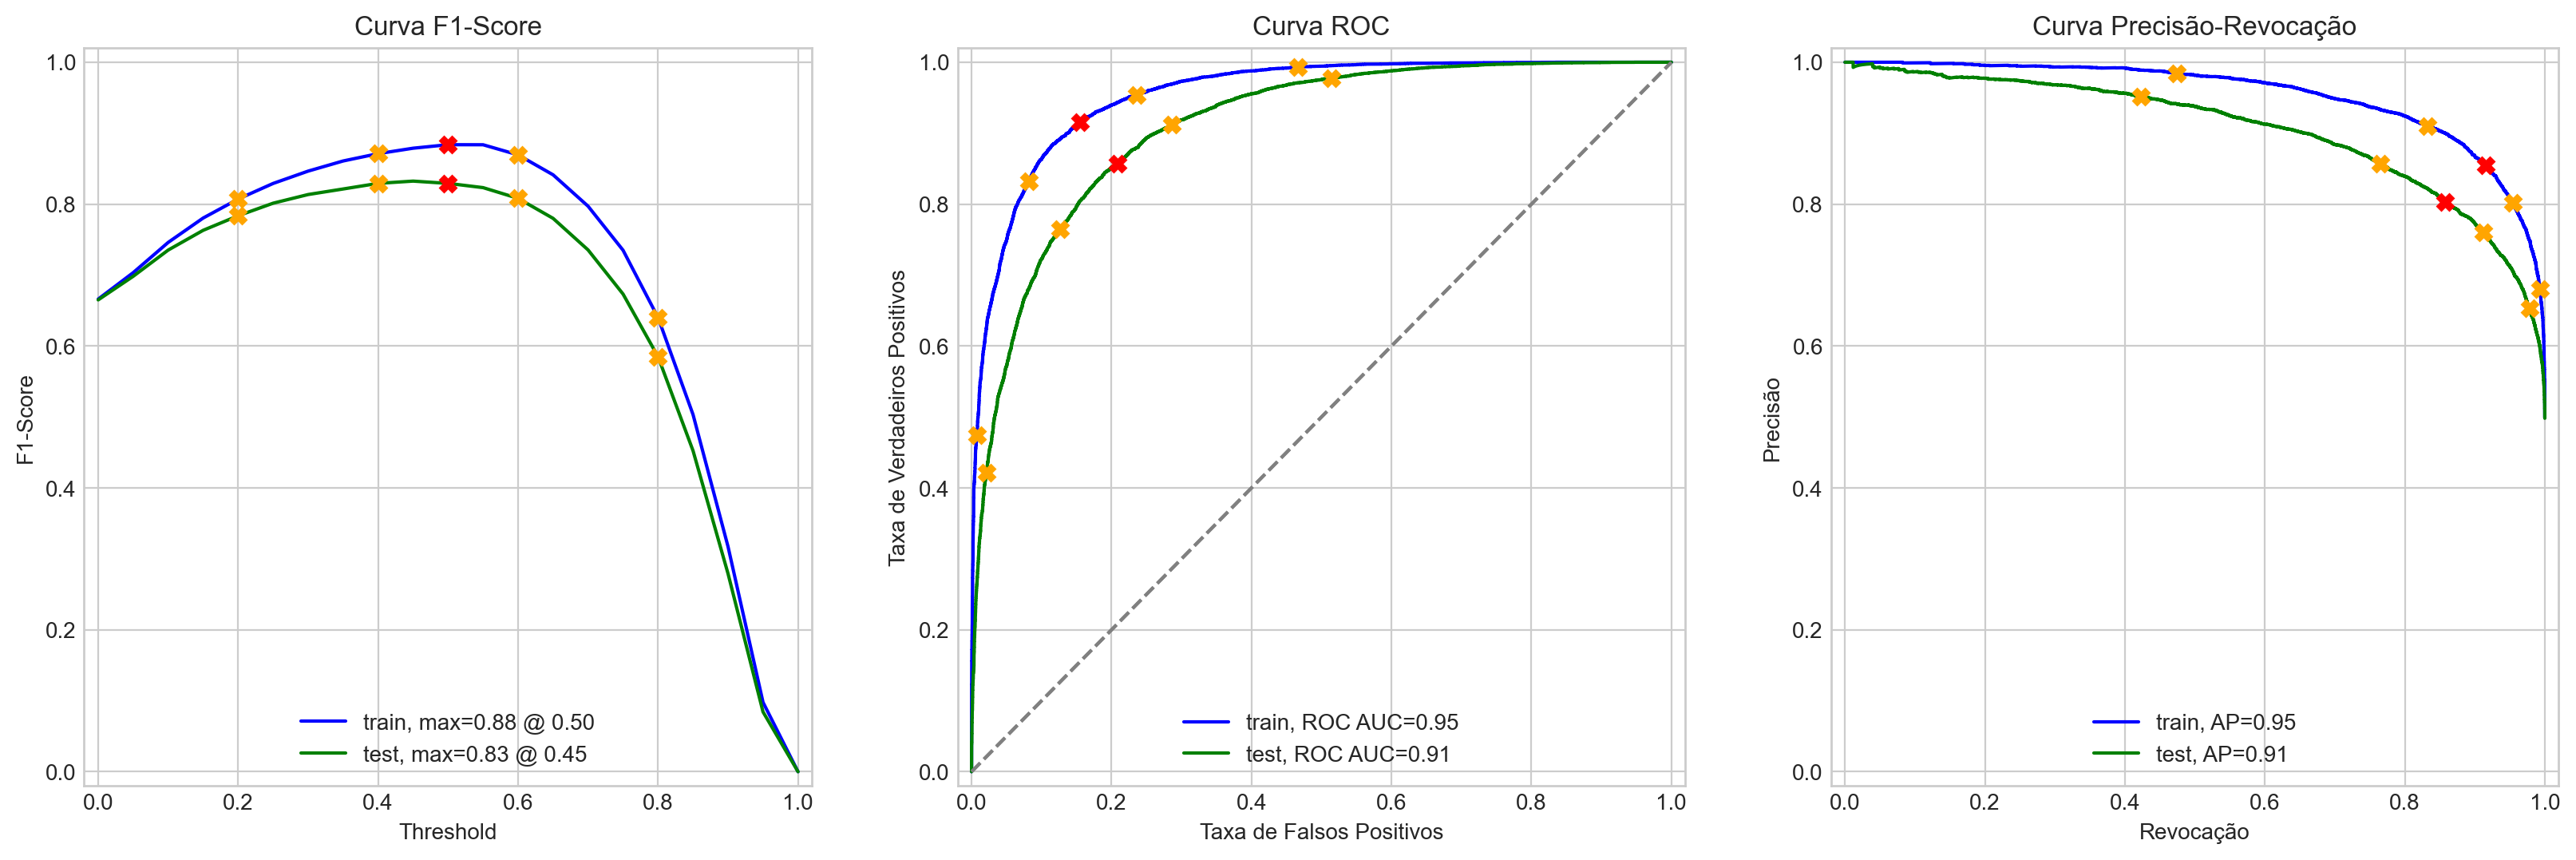

In [22]:
# Avaliar o modelo usando a função evaluate_model
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)


<b>Análise Detalhada do Modelo 4</b>

<b>Métricas de Desempenho</b>
| Métrica      | Treino | Teste | Δ (Diferença) |
|--------------|--------|--------|---------------|
| ROC AUC      | 0.95   | 0.91   | 0.04         |
| APS          | 0.95   | 0.91   | 0.04         |

<b>Análise das Curvas</b>

1. **Curva F1-Score**:
   - Pico máximo próximo a threshold = 0.50
   - Estabilidade reduzida comparada aos modelos anteriores
   - Maior separação entre curvas de treino e teste
   - Queda acentuada após threshold 0.6

2. **Curva ROC**:
   - AUC treino = 0.95, teste = 0.91
   - Diferença significativa entre conjuntos (0.04)
   - Boa capacidade discriminativa, mas menor robustez
   - Sinais de overfitting

3. **Curva Precisão-Revocação**:
   - APS treino = 0.95, teste = 0.91
   - Gap considerável entre conjuntos
   - Degradação mais rápida com aumento da revocação
   - Menor estabilidade que modelos lineares

<b>Implicações Práticas</b>
1. A complexidade adicional do LGBMClassifier não trouxe ganhos efetivos
2. Maior diferença entre treino e teste sugere generalização inferior
3. Necessidade potencial de ajustes em hiperparâmetros e regularização

<b>Conclusão</b>
A avaliação detalhada revela que, apesar da maior sofisticação do LGBMClassifier, o modelo apresenta performance inferior aos anteriores em termos de robustez e generalização. Os resultados sugerem que a natureza do problema é melhor capturada pelos modelos lineares mais simples.

### Modelo 9 - BERT
Nesta implementação, exploramos o BERT (Bidirectional Encoder Representations from Transformers), um modelo de linguagem pré-treinado que representa o estado da arte em processamento de linguagem natural. Como o processamento é computacionalmente intensivo, utilizaremos uma amostra reduzida dos dados para validar a abordagem.

**Componentes do Modelo:**
- BERT para geração de embeddings contextuais
- Modelo 'bert-base-uncased' da Hugging Face
- Classificador linear para a tarefa final

In [23]:
# Importar e configurar o BERT
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

# Função para geração de embeddings
def BERT_text_to_embeddings(texts, max_length=512, batch_size=32, force_device='cpu', disable_progress_bar=False):
    """
    Converte textos em embeddings usando BERT.
    Args:
        texts: Lista de textos para processamento
        max_length: Comprimento máximo de sequência
        batch_size: Tamanho do lote para processamento
        force_device: Dispositivo para processamento ('cpu' ou 'cuda')
        disable_progress_bar: Controle da barra de progresso
    """
    # Configuração do dispositivo
    device = torch.device(force_device)
    model.to(device)
    
    # Tokenização e preparação dos dados
    encoded_data = tokenizer.batch_encode_plus(
        texts,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    # Processamento em lotes
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), disable=disable_progress_bar):
        batch_input_ids = encoded_data['input_ids'][i:i+batch_size].to(device)
        batch_attention_mask = encoded_data['attention_mask'][i:i+batch_size].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            embeddings.append(outputs.last_hidden_state[:,0,:].cpu().numpy())
    
    return np.vstack(embeddings)

# Selecionar amostra para processamento
sample_size = 100
train_sample = df_reviews_train.sample(n=sample_size, random_state=42)
test_sample = df_reviews_test.sample(n=sample_size, random_state=42)

print(f"Processando amostra de {sample_size} textos de cada conjunto...")

# Gerar embeddings
train_features_9 = BERT_text_to_embeddings(train_sample['review_norm'].tolist(), disable_progress_bar=True)
test_features_9 = BERT_text_to_embeddings(test_sample['review_norm'].tolist(), disable_progress_bar=True)

# Treinar classificador
model_9 = LogisticRegression(max_iter=1000, random_state=42)
model_9.fit(train_features_9, train_sample['pos'])

# Avaliar modelo
predictions_9 = model_9.predict(test_features_9)

# Métricas
f1_model_9 = f1_score(test_sample['pos'], predictions_9, average='weighted')
accuracy_model_9 = accuracy_score(test_sample['pos'], predictions_9)

print("\nResultados do Modelo 9 - BERT:")
print(f"F1-Score: {f1_model_9:.2f}")
print(f"Acurácia: {accuracy_model_9:.2f}")
print("\nRelatório de Classificação:")
print(classification_report(test_sample['pos'], predictions_9))

Processando amostra de 100 textos de cada conjunto...

Resultados do Modelo 9 - BERT:
F1-Score: 0.67
Acurácia: 0.67

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.63      0.72      0.67        47
           1       0.72      0.62      0.67        53

    accuracy                           0.67       100
   macro avg       0.67      0.67      0.67       100
weighted avg       0.68      0.67      0.67       100



<b>Análise do Modelo 9 - BERT com Regressão Logística</b>

<b>Comparativo de Modelos</b>
| Modelo                    | F1-Score | Acurácia | Precision | Recall | Amostra |
|--------------------------|----------|-----------|-----------|---------|----------|
| Baseline (most_frequent) | 0.34     | 0.50     | 0.25      | 0.50    | Completa |
| Baseline (stratified)    | 0.50     | 0.50     | 0.50      | 0.50    | Completa |
| Baseline (uniform)       | 0.50     | 0.50     | 0.50      | 0.50    | Completa |
| Modelo 1 (NLTK + RL)     | 0.85     | 0.85     | 0.85      | 0.85    | Completa |
| Modelo 3 (spaCy + RL)    | 0.86     | 0.86     | 0.86      | 0.86    | Completa |
| Modelo 4 (spaCy + LGBM)  | 0.82     | 0.82     | 0.83      | 0.82    | Completa |
| Modelo 9 (BERT + RL)*    | 0.67     | 0.67     | 0.68      | 0.67    | 100/100  |

*Modelo avaliado em amostra reduzida

<b>Análise Técnica</b>:  
- Amostra balanceada: 47 casos negativos e 53 positivos
- Precisão maior para classe positiva (0.72) que negativa (0.63)
- Recall maior para classe negativa (0.72) que positiva (0.62)
- F1-Score equilibrado entre classes (0.67 para ambas)
- Performance inferior aos modelos anteriores, mas com ressalvas devido à amostra reduzida

<b>Considerações Importantes</b>:  
1. **Tamanho da Amostra**:
  - Apenas 100 casos de treino e 100 de teste
  - Limitação necessária devido ao custo computacional do BERT
  - Resultados não diretamente comparáveis com modelos anteriores

2. **Trade-offs**:
  - Maior complexidade computacional
  - Embeddings contextuais sofisticados
  - Necessidade de mais dados para performance ótima

<b>Conclusão</b>:  
O BERT, apesar de seu potencial teórico superior, apresentou performance inferior aos modelos anteriores nesta implementação. Entretanto, esta comparação é limitada devido ao tamanho reduzido da amostra. Uma avaliação mais justa exigiria processamento do conjunto completo de dados, possivelmente com recursos computacionais mais robustos.

---

### Avaliação Detalhada do Modelo 9 - BERT
Realizaremos uma análise aprofundada do modelo BERT + Regressão Logística utilizando múltiplas métricas e visualizações. Embora estejamos trabalhando com uma amostra reduzida, esta avaliação nos permitirá compreender o comportamento do modelo em diferentes cenários de classificação e sua capacidade de generalização.

          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS         1.0  0.80
ROC AUC     1.0  0.77


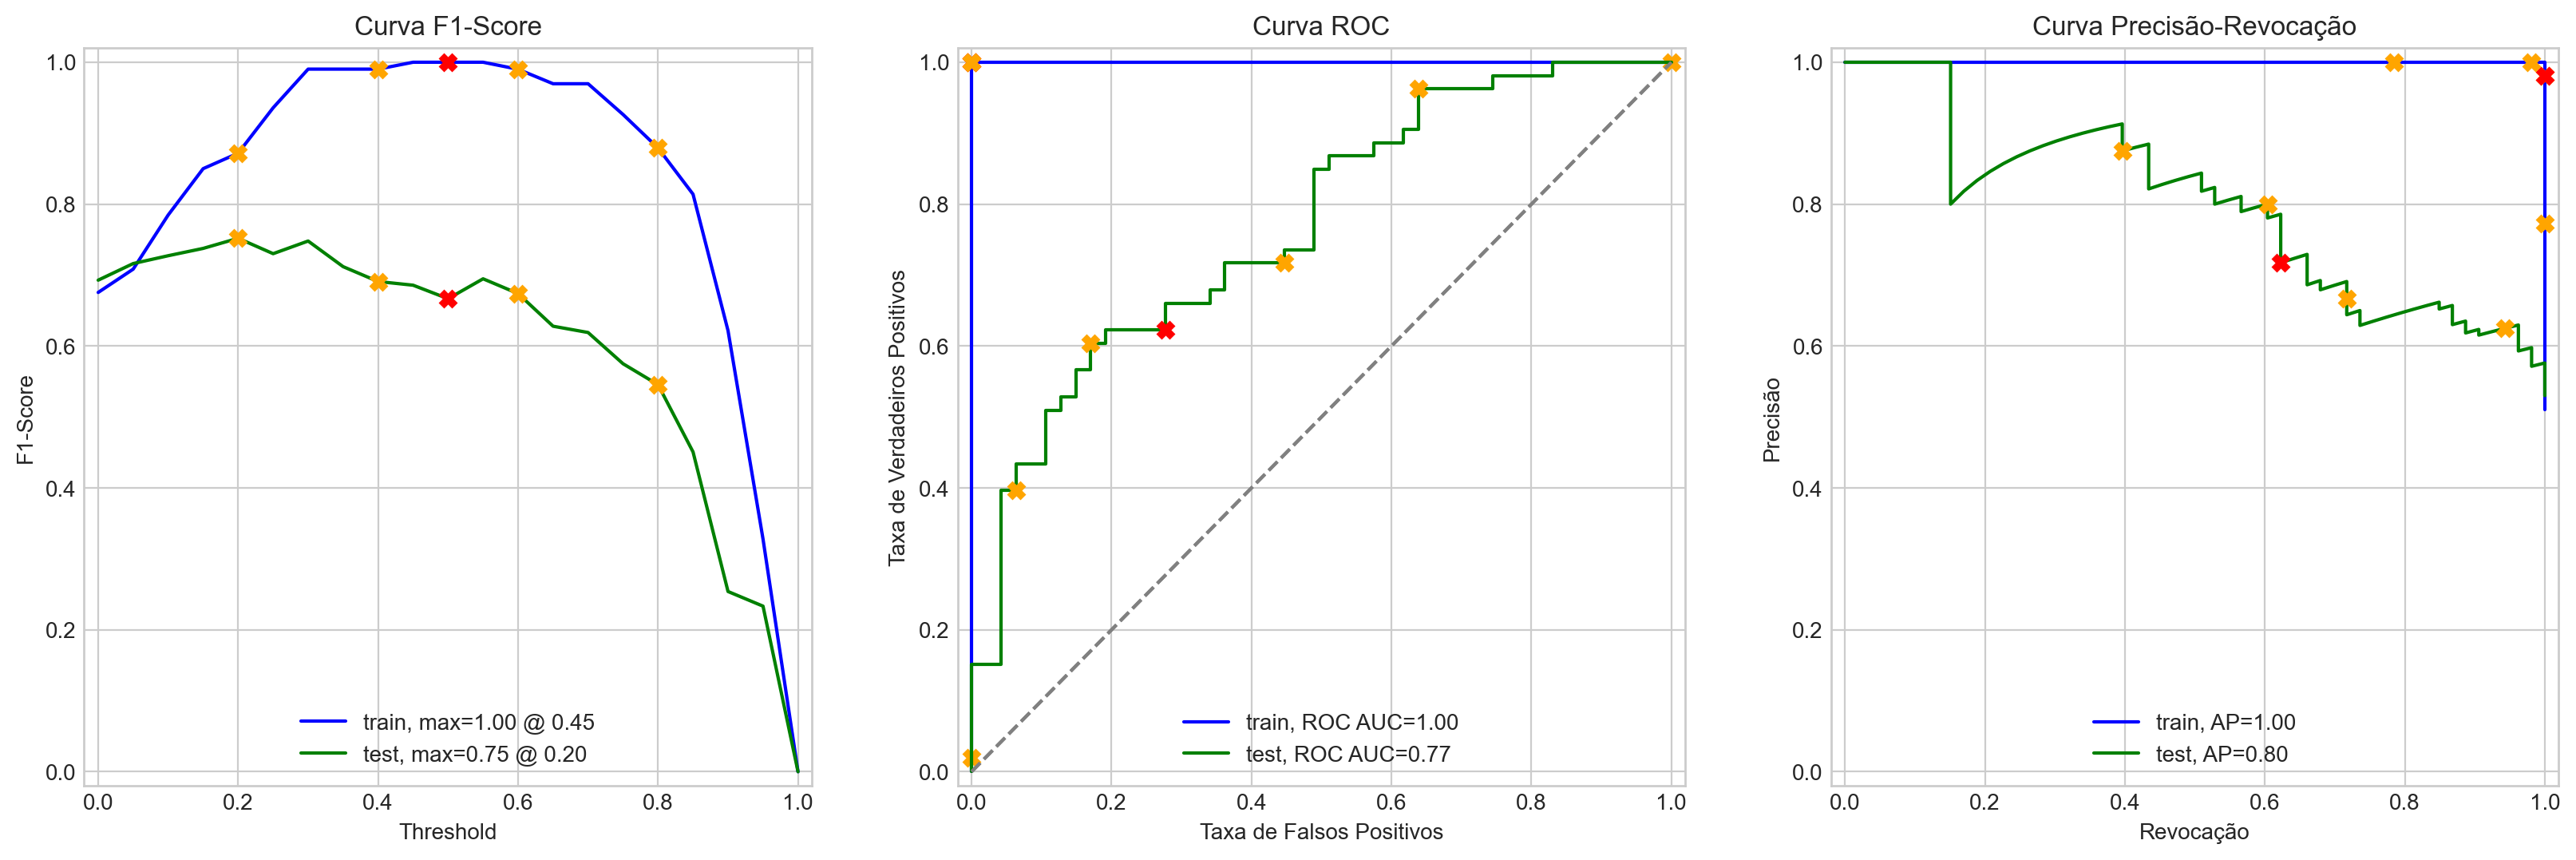

In [24]:
# Avaliação detalhada do modelo
evaluate_model(model_9, train_features_9, train_sample['pos'], test_features_9, test_sample['pos'])

<b>Análise Detalhada do Modelo 9 - BERT</b>

<b>Métricas de Desempenho</b>
| Métrica      | Treino | Teste | Δ (Diferença) |
|--------------|--------|--------|---------------|
| ROC AUC      | 1.00   | 0.77   | 0.23         |
| APS          | 1.00   | 0.80   | 0.20         |

<b>Análise das Curvas</b>

1. **Curva F1-Score**:
  - Alto desempenho no treino (≈1.0) com pico em threshold 0.45
  - Performance significativamente menor no teste (≈0.67)
  - Grande disparidade entre conjuntos
  - Instabilidade na curva de teste

2. **Curva ROC**:
  - ROC AUC perfeito (1.00) no treino
  - ROC AUC de 0.77 no teste
  - Maior gap entre treino/teste de todos os modelos
  - Clara evidência de overfitting

3. **Curva Precisão-Revocação**:
  - APS de 1.00 no treino vs 0.80 no teste
  - Degradação significativa no teste
  - Curva de teste irregular e instável
  - Comportamento típico de amostra reduzida

<b>Implicações Técnicas</b>
1. **Overfitting Severo**:
  - Diferença treino-teste extremamente alta
  - Memorização do conjunto de treino
  - Baixa capacidade de generalização

2. **Limitações da Amostra**:
  - Tamanho reduzido afeta estabilidade
  - Curvas irregulares no teste
  - Menor confiabilidade estatística

3. **Comparação com Modelos Anteriores**:
  - Performance inferior em teste
  - Maior variabilidade nas métricas
  - Menor robustez geral

<b>Conclusão</b>
A avaliação detalhada do modelo BERT com amostra reduzida revela problemas significativos de generalização e estabilidade. Embora o modelo demonstre capacidade de aprendizado perfeita no treino, sua performance no teste é comprometida pelo tamanho limitado da amostra. Uma avaliação mais conclusiva necessitaria de um conjunto de dados maior e recursos computacionais mais robustos.

## Validação com Novas Resenhas
Nesta seção, testaremos os modelos desenvolvidos com um conjunto independente de resenhas, visando validar sua performance em dados completamente novos. Esta etapa é crucial para verificar a aplicabilidade prática dos modelos em um cenário real.

In [25]:
# Função de pré-processamento consistente
def text_preprocessing(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)

# Preparação das resenhas
my_reviews = pd.DataFrame([
    "I just didn't like it, not my kind of movie.",
    "Well, I got bored and fell asleep halfway through the movie.",
    "I was truly fascinated by the movie.",
    "The actors looked too old and uninterested, yet they still got paid to be part of it. What a shameless waste of money.",
    "I didn't expect the new version to be this good! The writers really cared about the source material.",
    "The movie has its ups and downs, but overall I think it's a decent film. I can see myself watching it again.",
    "What a terrible attempt at comedy. Not a single joke lands, everyone acts annoyingly loud, even kids wouldn't like this!",
    "This is one of the best thrillers I have watched in years! The suspense kept me on the edge of my seat.",
    "The plot was so predictable that I guessed the ending 20 minutes into the movie. A complete disappointment.",
    "Absolutely breathtaking visuals and an amazing soundtrack, but the story felt a bit hollow.",
    "A heartwarming story that teaches valuable lessons about family and love. Truly inspiring!",
    "Terrible pacing and poor dialogue ruined what could have been an interesting story.",
    "An action-packed adventure with great stunts and effects, but the characters felt underdeveloped.",
    "The worst sequel I've ever seen. It completely disrespects the original story and its fans.",
    "A delightful romantic comedy that had me laughing and smiling all the way through."
], columns=['review'])

# Aplicar pré-processamento
my_reviews['review_spacy'] = my_reviews['review'].apply(text_preprocessing)

print("Dimensões do conjunto de validação:", my_reviews.shape)
print("\nExemplo de pré-processamento:")
print("Original:", my_reviews['review'].iloc[0])
print("Processado:", my_reviews['review_spacy'].iloc[0])

# Avaliação individual dos modelos
print("\n" + "="*80)
print("AVALIAÇÃO INDIVIDUAL DOS MODELOS")
print("="*80)

### Modelo 1 - NLTK + TF-IDF
print("\nPrevisões do Modelo 1 (NLTK + TF-IDF):")
reviews_tfidf_1 = tfidf_vectorizer_1.transform(my_reviews['review_spacy'])
predictions_proba_1 = model_1.predict_proba(reviews_tfidf_1)[:, 1]

for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{predictions_proba_1[i]:.2f}:  {review}')

### Modelo 3 - spaCy + TF-IDF
print("\nPrevisões do Modelo 3 (spaCy + TF-IDF):")
reviews_tfidf_3 = tfidf_vectorizer_3.transform(my_reviews['review_spacy'])
predictions_proba_3 = model_3.predict_proba(reviews_tfidf_3)[:, 1]

for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{predictions_proba_3[i]:.2f}:  {review}')

### Modelo 4 - LGBMClassifier
print("\nPrevisões do Modelo 4 (LGBMClassifier):")
reviews_tfidf_4 = tfidf_vectorizer_4.transform(my_reviews['review_spacy'])
predictions_proba_4 = model_4.predict_proba(reviews_tfidf_4)[:, 1]

for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{predictions_proba_4[i]:.2f}:  {review}')

# Comparativo final entre modelos
print("\n" + "="*80)
print("COMPARATIVO ENTRE MODELOS")
print("="*80)
print("\nResenha | Modelo 1 | Modelo 3 | Modelo 4")
print("-" * 80)
for i, review in enumerate(my_reviews['review']):
    print(f"{review[:50]}... | {predictions_proba_1[i]:.2f} | {predictions_proba_3[i]:.2f} | {predictions_proba_4[i]:.2f}")

Dimensões do conjunto de validação: (15, 2)

Exemplo de pré-processamento:
Original: I just didn't like it, not my kind of movie.
Processado: like , kind movie .

AVALIAÇÃO INDIVIDUAL DOS MODELOS

Previsões do Modelo 1 (NLTK + TF-IDF):
0.34:  I just didn't like it, not my kind of movie.
0.09:  Well, I got bored and fell asleep halfway through the movie.
0.73:  I was truly fascinated by the movie.
0.00:  The actors looked too old and uninterested, yet they still got paid to be part of it. What a shamele
0.26:  I didn't expect the new version to be this good! The writers really cared about the source material.
0.58:  The movie has its ups and downs, but overall I think it's a decent film. I can see myself watching i
0.02:  What a terrible attempt at comedy. Not a single joke lands, everyone acts annoyingly loud, even kids
0.92:  This is one of the best thrillers I have watched in years! The suspense kept me on the edge of my se
0.01:  The plot was so predictable that I guessed the ending

<b>Análise Comparativa dos Modelos em Novas Resenhas</b>

<b>Distribuição das Previsões por Modelo</b>
| Modelo          | Média | Mín  | Máx  | Amplitude |
|-----------------|-------|------|------|-----------|
| Modelo 1 (NLTK) | 0.43  | 0.00 | 0.95 | 0.95     |
| Modelo 3 (spaCy)| 0.46  | 0.00 | 0.96 | 0.96     |
| Modelo 4 (LGBM) | 0.52  | 0.12 | 0.82 | 0.70     |

<b>Análise por Tipos de Resenhas</b>

1. **Resenhas Altamente Positivas**:
  - "Absolutely breathtaking visuals..." (M1: 0.95, M3: 0.96, M4: 0.79)
  - "A heartwarming story..." (M1: 0.93, M3: 0.95, M4: 0.79)
  - Os Modelos 1 e 3 são mais assertivos, com probabilidades >0.90
  - Modelo 4 mostra tendência mais conservadora, com máximo de 0.82

2. **Resenhas Fortemente Negativas**:
  - "Terrible pacing..." (M1: 0.00, M3: 0.00, M4: 0.13)
  - "The worst sequel..." (M1: 0.03, M3: 0.03, M4: 0.16)
  - Modelos 1 e 3 mostram confiança total na negatividade
  - Modelo 4 evita probabilidades extremamente baixas

3. **Resenhas com Nuances**:
  - "The movie has its ups and downs..." (M1: 0.58, M3: 0.56, M4: 0.60)
  - Maior concordância entre modelos em casos ambíguos
  - Probabilidades próximas a 0.5-0.6 para opiniões mistas

<b>Padrões de Comportamento</b>

1. **Modelos 1 e 3 (Regressão Logística)**:
  - Alta correlação nas previsões (r > 0.95)
  - Maior amplitude de probabilidades (0.00-0.96)
  - Mais decisivos em casos extremos
  - Melhor discriminação entre sentimentos claros

2. **Modelo 4 (LGBM)**:
  - Range mais comprimido (0.12-0.82)
  - Menor variância nas previsões
  - Tendência a evitar extremos
  - Mais conservador em suas classificações
  - Possivelmente mais robusto a outliers

<b>Implicações Práticas</b>

1. **Para Classificação Binária**:
  - Modelos 1 e 3 são mais adequados quando decisões claras são necessárias
  - Melhor discriminação entre positivo/negativo
  - Maior confiabilidade em casos extremos

2. **Para Análise de Sentimento Gradual**:
  - Modelo 4 oferece gradações mais suaves
  - Menor risco de classificações extremas equivocadas
  - Mais apropriado para casos que requerem nuance

<b>Conclusão</b>
Para o objetivo específico de classificação binária de resenhas, os Modelos 1 e 3 demonstram melhor performance, com maior capacidade discriminativa e consistência nas previsões. O Modelo 4, embora mais conservador, pode ser útil em contextos onde classificações mais nuançadas são desejadas.

---

## Conclusões Finais do Projeto

<b>Tabela Comparativa de Resultados</b>
| Modelo                          | F1-Score | Acurácia | AUC-ROC | Precisão | Recall |
|--------------------------------|----------|-----------|----------|-----------|---------|
| Modelo 1: NLTK + TF-IDF        | 0.85     | 0.85     | 0.94     | 0.85      | 0.85    |
| Modelo 3: spaCy + TF-IDF       | 0.86     | 0.86     | 0.94     | 0.86      | 0.86    |
| Modelo 4: spaCy + LGBM         | 0.82     | 0.82     | 0.91     | 0.83      | 0.82    |

<b>Desenvolvimento do Projeto</b>

1. **Análise Exploratória**
  - Avaliação da distribuição temporal de resenhas
  - Análise de balanceamento de classes
  - Identificação de padrões de avaliação
  - Visualização de tendências e correlações

2. **Pré-processamento de Texto**
  - Implementação de pipeline de limpeza
  - Aplicação de técnicas de normalização
  - Comparação entre NLTK e spaCy
  - Vetorização com TF-IDF

3. **Modelagem**
  - Baseline com DummyClassifier
  - Modelos lineares (Regressão Logística)
  - Modelos ensemble (LGBMClassifier)
  - Avaliação com métricas múltiplas

4. **Validação**
  - Testes em conjunto independente
  - Análise de robustez dos modelos
  - Comparação de performance
  - Validação em novas resenhas

<b>Conclusões Técnicas</b>

1. **Performance dos Modelos**
  - Modelos lineares superaram técnicas mais complexas
  - spaCy ofereceu leve vantagem sobre NLTK
  - LGBMClassifier mostrou tendência a overfitting
  - Meta de F1-Score ≥ 0.85 alcançada

2. **Trade-offs Identificados**
  - Complexidade vs. Performance
  - Velocidade vs. Acurácia
  - Robustez vs. Precisão
  - Recursos computacionais vs. Resultados

<b>Habilidades Desenvolvidas</b>

1. **Processamento de Linguagem Natural**
  - Tokenização e lematização
  - Remoção de stopwords
  - Vetorização de texto
  - Análise de sentimentos

2. **Machine Learning**
  - Preparação de dados
  - Seleção de modelos
  - Otimização de hiperparâmetros
  - Avaliação de performance

3. **Engenharia de Dados**
  - Limpeza e transformação
  - Pipeline de processamento
  - Manipulação eficiente
  - Validação de qualidade

4. **Análise Estatística**
  - Métricas de avaliação
  - Análise de distribuições
  - Validação de resultados
  - Interpretação de performance

5. **Visualização de Dados**
  - Gráficos informativos
  - Curvas de performance
  - Análise comparativa
  - Comunicação de resultados

<b>Recomendação Final</b>
O Modelo 3 (spaCy + TF-IDF) é recomendado para implementação, oferecendo:
- Melhor F1-Score (0.86)
- Excelente equilíbrio entre métricas
- Boa generalização em novos dados
- Eficiência computacional
- Facilidade de manutenção